Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [1]:
# # Install a pip package in the current Jupyter kernel 🚨RUN THIS CELL ONCE FOR YOUR ENVIRONMENT
# import sys
# !"{sys.executable}" -m pip install "aerosandbox[full]"
# !"{sys.executable}" -m pip install "gymnasium[all]"
# !"{sys.executable}" -m pip install "stable_baselines3[extra]"
# !"{sys.executable}" -m pip install "tensorboard"

Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [2]:
#Helper
import aerosandbox.numpy as np
def flatten_list(nested_item):
    flattened = []
    
    if isinstance(nested_item, (list, np.ndarray)):
        for item in nested_item:
            flattened.extend(flatten_list(item))
    else:
        flattened.append(nested_item)
    
    return flattened

def offsetsToLocations(offsets, minXGap):
    # Initialize an empty list to store the resulting locations
    locations = []
    # Initialize the starting location
    previous_location = [0, 0, 0]
    current_location = [0, 0, 0]
    
    # Iterate through each offset in the list
    for offset in offsets:
        locations.append(current_location.copy())
        previous_location = current_location.copy()
        current_location = [
            current_location[0] + offset[0],
            current_location[1] + offset[1],
            current_location[2] + offset[2],
        ]
        if(current_location[1] - previous_location[1] < minXGap):
            current_location[1] = previous_location[1] + minXGap
        
    
    return locations

def locationsToOffsets(locations):
    # Initialize an empty list to store the resulting offsets
    offsets = []
    
    # Initialize the previous location
    prev_location = [0, 0, 0]
    
    # Iterate through each location in the list
    for location in locations:
        # Calculate the offset as the difference between the current and previous locations
        offset = [location[i] - prev_location[i] for i in range(3)]
        
        # Append the offset to the list of offsets
        offsets.append(offset)
        
        # Update the previous location for the next iteration
        prev_location = location
    
    return offsets

In [3]:
import aerosandbox as asb
import gymnasium as gym
from gymnasium import spaces
import numpy as np
	
class AeroEnv(gym.Env):

	# construct and save self.airplane from self.xsecs
	def constructAirplane(self):
		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[asb.Wing(
					name="Wing",    
					symmetric=True,
					xsecs=self.xsecs
				)],
		)
	
	#attempting to constraint reward
	def getReward(self):
		lift = self.aero["L"]
		drag = self.aero["D"]
		reward = lift/drag
		reward = reward - self.airplane.wings[0].volume()/100
		
		if(drag < 0 or lift < 0 or lift > 300 or drag > 300):
			reward = 0

		# if(reward > 120): #likely a ridiculous value
		# 	reward = -(reward - 120)
		
		#final constraints, to prevent insanely negative rewards
		reward = max(reward, 0)
		reward = min(reward, 150)
		# reward = reward*(self.currStep+1)/self.episodeSteps
			

		return reward

	# construct and safe self.vlm()
	def runAero(self):
		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			),
			
		)
		self.vlm.run_symmetric = True
		self.aero = self.vlm.run()
		
	# get observations from current self.xsecs
	def get_observation_vector(self):
		obs = []
		for xsec in self.xsecs:
			# xyz_le is a list of three values
			obs.extend(xsec.xyz_le)
			
			# chord and twist are single values
			obs.append(xsec.chord)
			obs.append(xsec.twist)

			# KulfanAirfoil attributes
			# Both upper_weights and lower_weights are numpy arrays
			obs.extend(xsec.airfoil.upper_weights.tolist())
			obs.extend(xsec.airfoil.lower_weights.tolist())

			# leading_edge_weight, N1, and N2 are single values
			obs.append(xsec.airfoil.leading_edge_weight)
			obs.append(xsec.airfoil.N1)
			obs.append(xsec.airfoil.N2)
		# Append aerodynamics output at the end
		# - 'F_g' : an [x, y, z] list of forces in geometry axes [N]
		# - 'F_b' : an [x, y, z] list of forces in body axes [N]
		# - 'F_w' : an [x, y, z] list of forces in wind axes [N]
		# - 'M_g' : an [x, y, z] list of moments about geometry axes [Nm]
		# - 'M_b' : an [x, y, z] list of moments about body axes [Nm]
		# - 'M_w' : an [x, y, z] list of moments about wind axes [Nm]
		# - 'L' : the lift force [N]. Definitionally, this is in wind axes.
		# - 'Y' : the side force [N]. This is in wind axes.
		# - 'D' : the drag force [N]. Definitionally, this is in wind axes.
		# - 'l_b', the rolling moment, in body axes [Nm]. Positive is roll-right.
		# - 'm_b', the pitching moment, in body axes [Nm]. Positive is pitch-up.
		# - 'n_b', the yawing moment, in body axes [Nm]. Positive is nose-right.
		# - 'CL', the lift coefficient [-]. Definitionally, this is in wind axes.
		# - 'CY', the sideforce coefficient [-]. This is in wind axes.
		# - 'CD', the drag coefficient [-]. Definitionally, this is in wind axes.
		# - 'Cl', the rolling coefficient [-], in body axes
		# - 'Cm', the pitching coefficient [-], in body axes
		# - 'Cn', the yawing coefficient [-], in body axes
		drag = self.aero["D"]
		lift = self.aero["L"]
		drag = np.tanh((drag-50)/50)
		lift = np.tanh((lift-50)/50)
		obs.append(lift)
		obs.append(drag)
		obs.append(self.currStep)
		return np.array(obs, dtype=np.float32)
	
	def __init__(self, 
			  # === Key Parameters ===
			  episodeSteps,
			  kulfanWeightResolution, 	#How many kulfan weights per XSec? More = more intricate designs. Something like 5-8 should be enough...
			  numChords, 				#How many independently controlled foils along length of wing 
			  minChordSpacing,
			  minChordLength,

			  # === Initial Values ===
			  initialYSpacing, 			#Initial spacing of the cross sections
			  initialChordLength, 		#Initial length from front to back of each cross section in wing
			  initialUpperKulfan, 		#Upper kulfan weight initial values (controls curvature of top of wing)
			  initialLowerKulfan, 		#Lower Kulfan weight initial values (controls curvature of bottom of wing)
			  initialLEW, 				#Leading edge weight initial values
			  initialN1, 				#Initial N1 value (forward shift of wing curve shape)
			  initialN2, 				#Initial N2 value (backwards shift of wing curve shape)
			  
			  # === Changing Values ===
			  dX_bounds, 				#How much to allow shift of each cross section per time step in forward/backwards direction
			  dY_bounds, 				#How much to allow shift of each cross section per time step in left/right direction (stubbier wings)
			  dZ_bounds, 				#How much to allow shift of each cross section per time step in up/down direction (wingtips?)
			  dChord_bounds, 			#How much to allow each cross section to change in length per timestep (wider wings? front-back length)
			  dTwist_bounds, 			#How much (in DEGREES) to allow rotation of each cross section per timestep about leading edge
			  KT_bounds, 				#Min/max upper kulfan weights (should be 0,>0)
			  KB_bounds, 				#Max lower kulfan weights (should be <0,0 unless you want to create gaps on bottom of wing that arc up)
			  N_bounds, 				#Bounds of either N value (1, ?)
			  LEW_bounds, 				#Bounds of leading edge weight (??? TODO: Learn what the fuck this does lmao. Experiment)
		):
		super(AeroEnv, self).__init__() #Initialize gym enviro
		self.numChords = numChords
		self.kulfanWeightResolution = kulfanWeightResolution
		self.minChordSpacing = minChordSpacing
		self.minChordLength = minChordLength
		self.episodeSteps = episodeSteps
		
		# Lower and upper bounds for each of the parameters
		low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
		high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)
		self.vectorLengthPerXSec = len(low)
		# Creates a much bigger vector, action bounds PER cross section.
		oLow = low.copy()
		oHigh = high.copy()
		low = np.tile(low, numChords) 
		high = np.tile(high, numChords)

		# === Establish bounds for leading edges === 
		oLow[0]=oLow[0]*episodeSteps + 0 # 0 here is the initial value min
		oLow[1]=0 # 0 here is the initial value min
		oLow[2]=oLow[2]*episodeSteps + 0 # 0 here is the initial value min

		oHigh[0]=oHigh[0]*episodeSteps + 0 # 0 here is the initial value max
		oHigh[1]=oHigh[1]*episodeSteps*numChords # initial value max is gonna be the farthest chord out
		oHigh[2]=oHigh[2]*episodeSteps + 0 # 0 here is the initial value max

		# === Establish bounds for CHORD and TWIST === 
		oLow[3]=oLow[3]*episodeSteps + initialChordLength 
		oLow[4]=oLow[4]*episodeSteps + 0 

		oHigh[3]=oHigh[3]*episodeSteps + initialChordLength
		oHigh[4]=oHigh[4]*episodeSteps + 0

		# === Establish KT / KB weight bounds, N bounds, LEW bounds ===
		# No need because absolute value, so bounds are same as action bounds

		oLow = np.tile(oLow, numChords) 
		oHigh = np.tile(oHigh, numChords)

		# === Establish Aerodynamic Bounds (AFTER tiling because not 1 per chord) ===
		oLow = np.append(oLow, [-1, -1]) #Lift, Drag: I intend to use tanH
		oHigh = np.append(oHigh, [1, 1]) #Lift, Drag: I intend to use tanH		

		# === Establish Episode Bounds (AFTER tiling because not 1 per chord) ===
		oLow = np.append(oLow, 0) 
		oHigh = np.append(oHigh, episodeSteps) 	

		self.observation_space = spaces.Box(low=oLow, high=oHigh, dtype=np.float32) #there are 18 additional values provided by vlm.run(), but Im just using 2, Lift and Drag
		self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)
		

		# Initial values for cross sections
		self.init_xyz_le_offsets = [[0, initialYSpacing, 0]]*self.numChords
		self.init_chord = [initialChordLength] * self.numChords  														
		self.init_twist = [0] * self.numChords  														
		self.init_upper_weights = [np.array([initialUpperKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_lower_weights = [np.array([initialLowerKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_leading_edge_weight = [initialLEW] * self.numChords  										
		self.init_N1 = [initialN1] * self.numChords 															
		self.init_N2 = [initialN2] * self.numChords


		self.init_xyz_le = offsetsToLocations(self.init_xyz_le_offsets, minXGap=self.minChordSpacing)
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i],
			)
		) for i in range(self.numChords)]
		self.constructAirplane()
		self.currStep = 0
		
	def step(self, action):
		self.currStep += 1
		#Turn chord positions into offsets
		currPos=[]
		for i in range(self.numChords):
			# Apply dX, dY, dZ
			currPos.append([
				self.xsecs[i].xyz_le[0],
				self.xsecs[i].xyz_le[1],
				self.xsecs[i].xyz_le[2]
			])
		
		offsets = locationsToOffsets(currPos)
		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec
			# Apply dX, dY, dZ
			offsets[i] = [
				offsets[i][0] + action[idx], 		#x + dx
				offsets[i][1] + action[idx + 1],	#y + dy
				offsets[i][2] + action[idx + 2]		#z + dz
			]
		
		newXYZ_le_positions = offsetsToLocations(offsets, minXGap=self.minChordSpacing)

		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec
			newXYZ_le = newXYZ_le_positions[i]
			# Apply dChord, dTwist
			newChord = self.xsecs[i].chord + action[idx + 3] #chord + dchord
			newTwist = self.xsecs[i].twist + action[idx + 4]

			# Set KB, KT 
			newUpper_weights = np.array([action[idx + 5 + j] for j in range(self.kulfanWeightResolution)], np.float32)
			newLower_weights = np.array([action[idx + 5+self.kulfanWeightResolution + j] for j in range(self.kulfanWeightResolution)], np.float32)
			
			# Set LEW, N1, N2
			newLeading_edge_weight = action[idx + 5+2*self.kulfanWeightResolution] 	# LEW = action's LEW
			newN1 = action[idx + 6+2*self.kulfanWeightResolution] 					# N1 = action's N1
			newN2 = action[idx + 7+2*self.kulfanWeightResolution]					# N2 = action's N2

			self.xsecs[i] = asb.WingXSec(
				xyz_le=([0,0,0] if i == 0 else newXYZ_le), #might not be needed
				chord=max(newChord, self.minChordLength),
				twist=newTwist,
				airfoil=asb.KulfanAirfoil(
					leading_edge_weight=newLeading_edge_weight,
					lower_weights=newLower_weights,
					upper_weights=newUpper_weights,
					N1=newN1,
					N2=newN2
				)
			)

		self.constructAirplane()
		self.runAero()
		
		obs = self.get_observation_vector()				# observation (ObsType): An element of the environment's observation_space as the next observation due to the agent actions.
		reward = self.getReward()						# reward (SupportsFloat): The reward as a result of taking the action.
		terminated = bool(reward >= 120) 				# terminated (bool): Whether the agent reaches the terminal state (as defined under the MDP of the task)
		truncated = bool(reward >= 120)	 				# truncated (bool): Whether the truncation condition outside the scope of the MDP is satisfied.
		info = {"lift": self.aero["L"], "drag": self.aero["L"]}	# info (dict): Contains auxiliary diagnostic information (helpful for debugging, learning, and logging).
		
		return obs, reward, terminated, truncated, info 
    
	def reset(self, seed=123):
		super().reset(seed=seed)
		self.currStep = 0
		# Reinitialize wing sections to their initial states
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]

		randomAction = self.action_space.sample()
		self.step(randomAction)

		self.constructAirplane()
		self.runAero()
		
		liftCoeff = self.aero["CL"]
		dragCoeff = self.aero["CD"]

		obs = self.get_observation_vector()
		info = {"lift": liftCoeff, "drag": dragCoeff} 
		return obs, info
	
	def render(self):
		self.runAero()
		print(self.aero)
		self.airplane.draw_three_view()
		# self.vlm.draw()
	
	def close (self):
		...

In [4]:
# ##SanityCheck
# env = AeroEnv(
#     episodeSteps=40,
#     numChords=5, 
#     minChordLength=0.1,
#     minChordSpacing=0.4,
# 	initialYSpacing=0.15, 
# 	initialChordLength=0.1, 
# 	initialUpperKulfan=1, 
# 	initialLowerKulfan=-0.2, 
# 	initialLEW=0, 
# 	initialN1=3, 
# 	initialN2=1, 
#     dX_bounds = (-0.05, 0.05),
# 	dY_bounds = (-0.2, 0.2),
# 	dZ_bounds = (0, 0),
# 	dChord_bounds = (-0.1, 0.1),
# 	dTwist_bounds = (0, 0),
# 	KT_bounds = (0, 1),
# 	KB_bounds = (-1, 0),
# 	N_bounds = (1, 4),
# 	LEW_bounds = (0, 0.3),
# 	kulfanWeightResolution = 7)

# obs = env.reset()
# random_action = env.action_space.sample()
# env.step(random_action)
# env.render()



In [5]:
steps = 10 #steps per episode used in model training before resetting

def make_env():
    def _init():
        env = AeroEnv(
            episodeSteps=steps,
            numChords=4, 
            minChordLength=0.2,
            minChordSpacing=0.1,
            initialYSpacing=1, 
            initialChordLength=1, 
            initialUpperKulfan=1, 
            initialLowerKulfan=-0.3, 
            initialLEW=0.1, 
            initialN1=1, 
            initialN2=1, 
            dX_bounds = (-1, 0),
            dY_bounds = (-1, 1),
            dZ_bounds = (0, 0),
            dChord_bounds = (-0.5, 0.5),
            dTwist_bounds = (0, 0),
            KT_bounds = (0, 0.6),
            KB_bounds = (-0.2, 0),
            N_bounds = (1, 3),
            LEW_bounds = (0, 0.1),
            kulfanWeightResolution = 3
        )
        return env
    return _init

In [6]:
from stable_baselines3 import PPO
import os
import time
# from stable_baselines3.common.callbacks import EvalCallback
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3.common.vec_env import VecNormalize
import copy

models_dir = f"models/A2C-{int(time.time())}"
logdir = f"logs/A2C-{int(time.time())}"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

# envs = [make_env() for _ in range(3)]
# env = DummyVecEnv(envs)
# env = VecNormalize(env)
env = make_env()()
# evalEnv = copy.deepcopy(env)
# eval_callback = EvalCallback(
#     eval_env=evalEnv, 
#     best_model_save_path='./logs/best_model/',
#     log_path='./logs/eval_log/', 
#     eval_freq=1000)

# TODO: find a way to use eval callback that doesnt add 10 minutes per eval to the run

model = PPO(
	n_steps=steps,
    batch_size=steps,
	policy="MlpPolicy",
	env=env,
    n_epochs=1,
    learning_rate=.0001,
	verbose=0,
    tensorboard_log=logdir,
)

total_timesteps = 1000
model.learn(total_timesteps=total_timesteps, progress_bar=True)

print("We lerned")

Output()

0

1

2

3

4

5

6

7

8

9

===

{'F_g': array([ 5.12184230e+11,  2.13985591e+04, -1.88500176e+11]), 'F_b': (-512184230231.08734, 
21398.559137677978, 188500176432.41995), 'F_w': (-512184230231.08734, 21398.559137677978, 188500176432.41995), 
'M_g': array([-5.76988936e+03,  5.99777938e+11,  4.47624182e+04]), 'M_b': (5769.889357750479, 599777938157.5375, 
-44762.41823814454), 'M_w': (5769.889357750479, 599777938157.5375, -44762.41823814454), 'L': -188500176432.41995, 
'D': 512184230231.08734, 'Y': 21398.559137677978, 'l_b': 5769.889357750479, 'm_b': 599777938157.5375, 'n_b': 
-44762.41823814454, 'CL': -71411112.2544923, 'CD': 194035073.3471372, 'CY': 8.106596702380054, 'Cl': 
0.3325203821475585, 'Cm': 121531789.37763692, 'Cn': -2.5796710292898393}

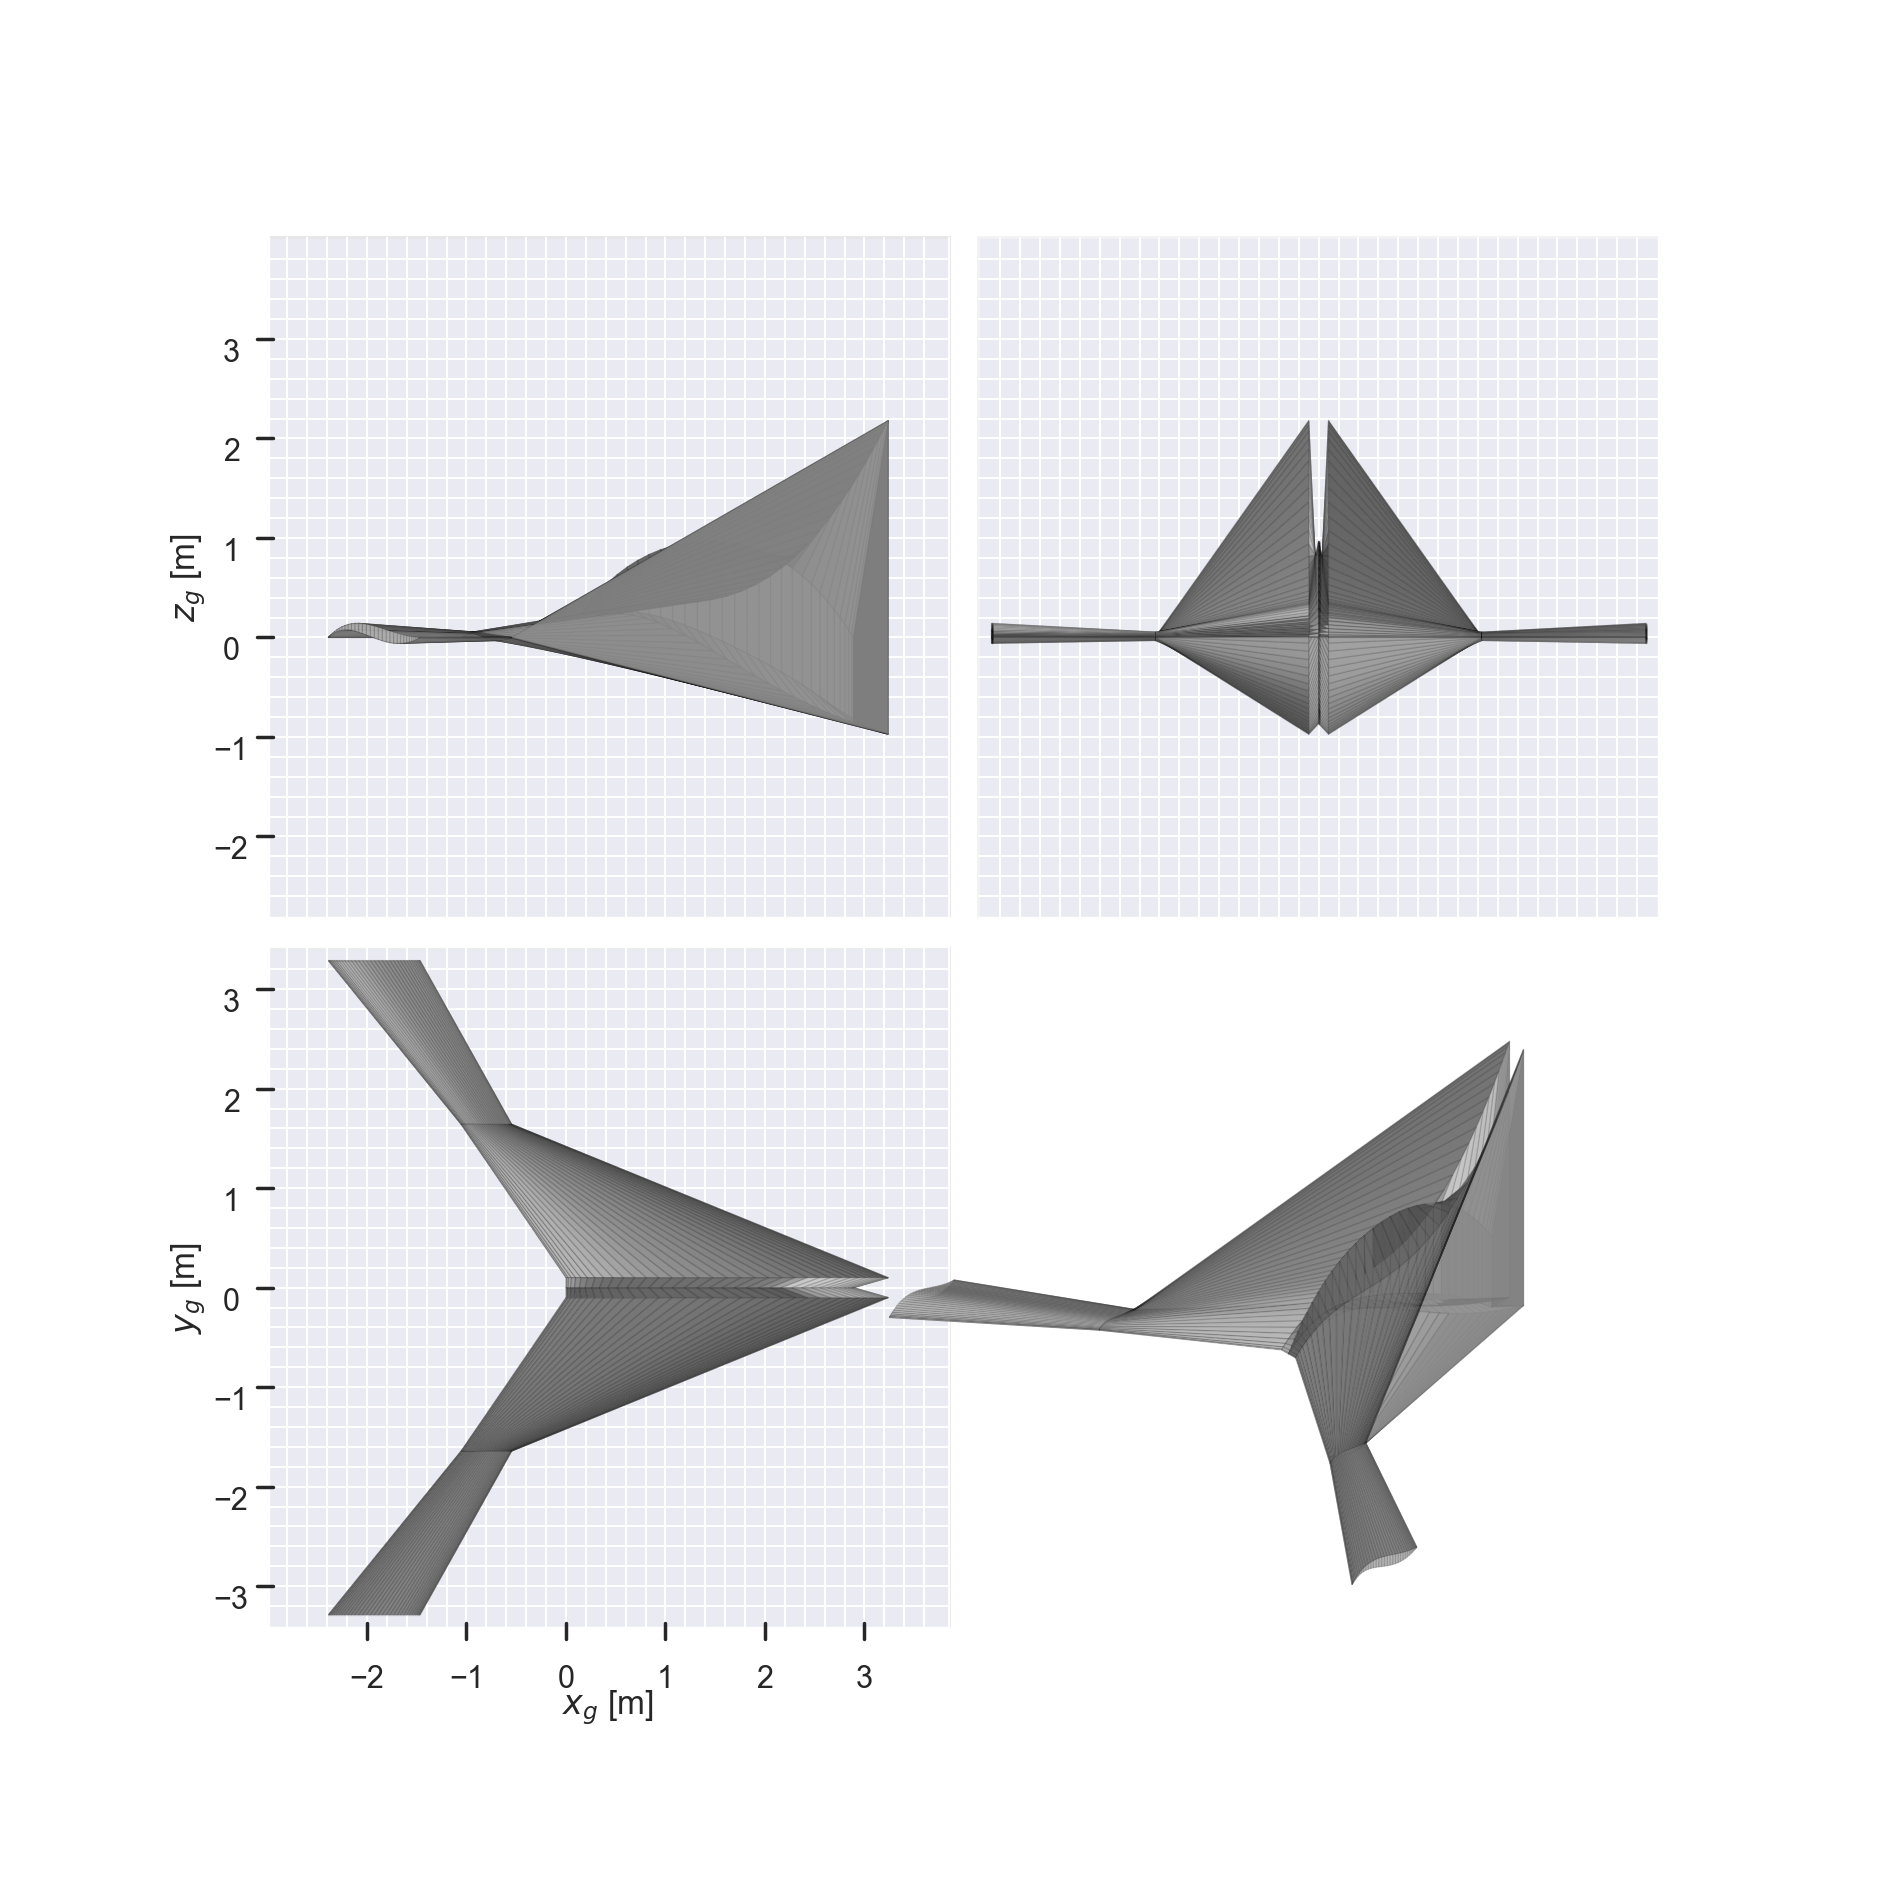

0

1

2

3

4

5

6

7

8

9

===

{'F_g': array([ 2.59596164e+12,  1.08407241e+03, -1.10690932e+13]), 'F_b': (-2595961644351.7974, 1084.072413241771,
11069093211290.701), 'F_w': (-2595961644351.7974, 1084.072413241771, 11069093211290.701), 'M_g': 
array([1.58946833e+02, 1.93777562e+13, 2.29569628e+03]), 'M_b': (-158.94683311329314, 19377756162228.453, 
-2295.6962756706353), 'M_w': (-158.94683311329314, 19377756162228.453, -2295.6962756706353), 'L': 
-11069093211290.701, 'D': 2595961644351.7974, 'Y': 1084.072413241771, 'l_b': -158.94683311329314, 'm_b': 
19377756162228.453, 'n_b': -2295.6962756706353, 'CL': -7785158348.176611, 'CD': 1825801994.914732, 'CY': 
0.7624540905815571, 'Cl': -0.04682361303382627, 'Cm': 6419746151.364775, 'Cn': -0.6762814454980676}

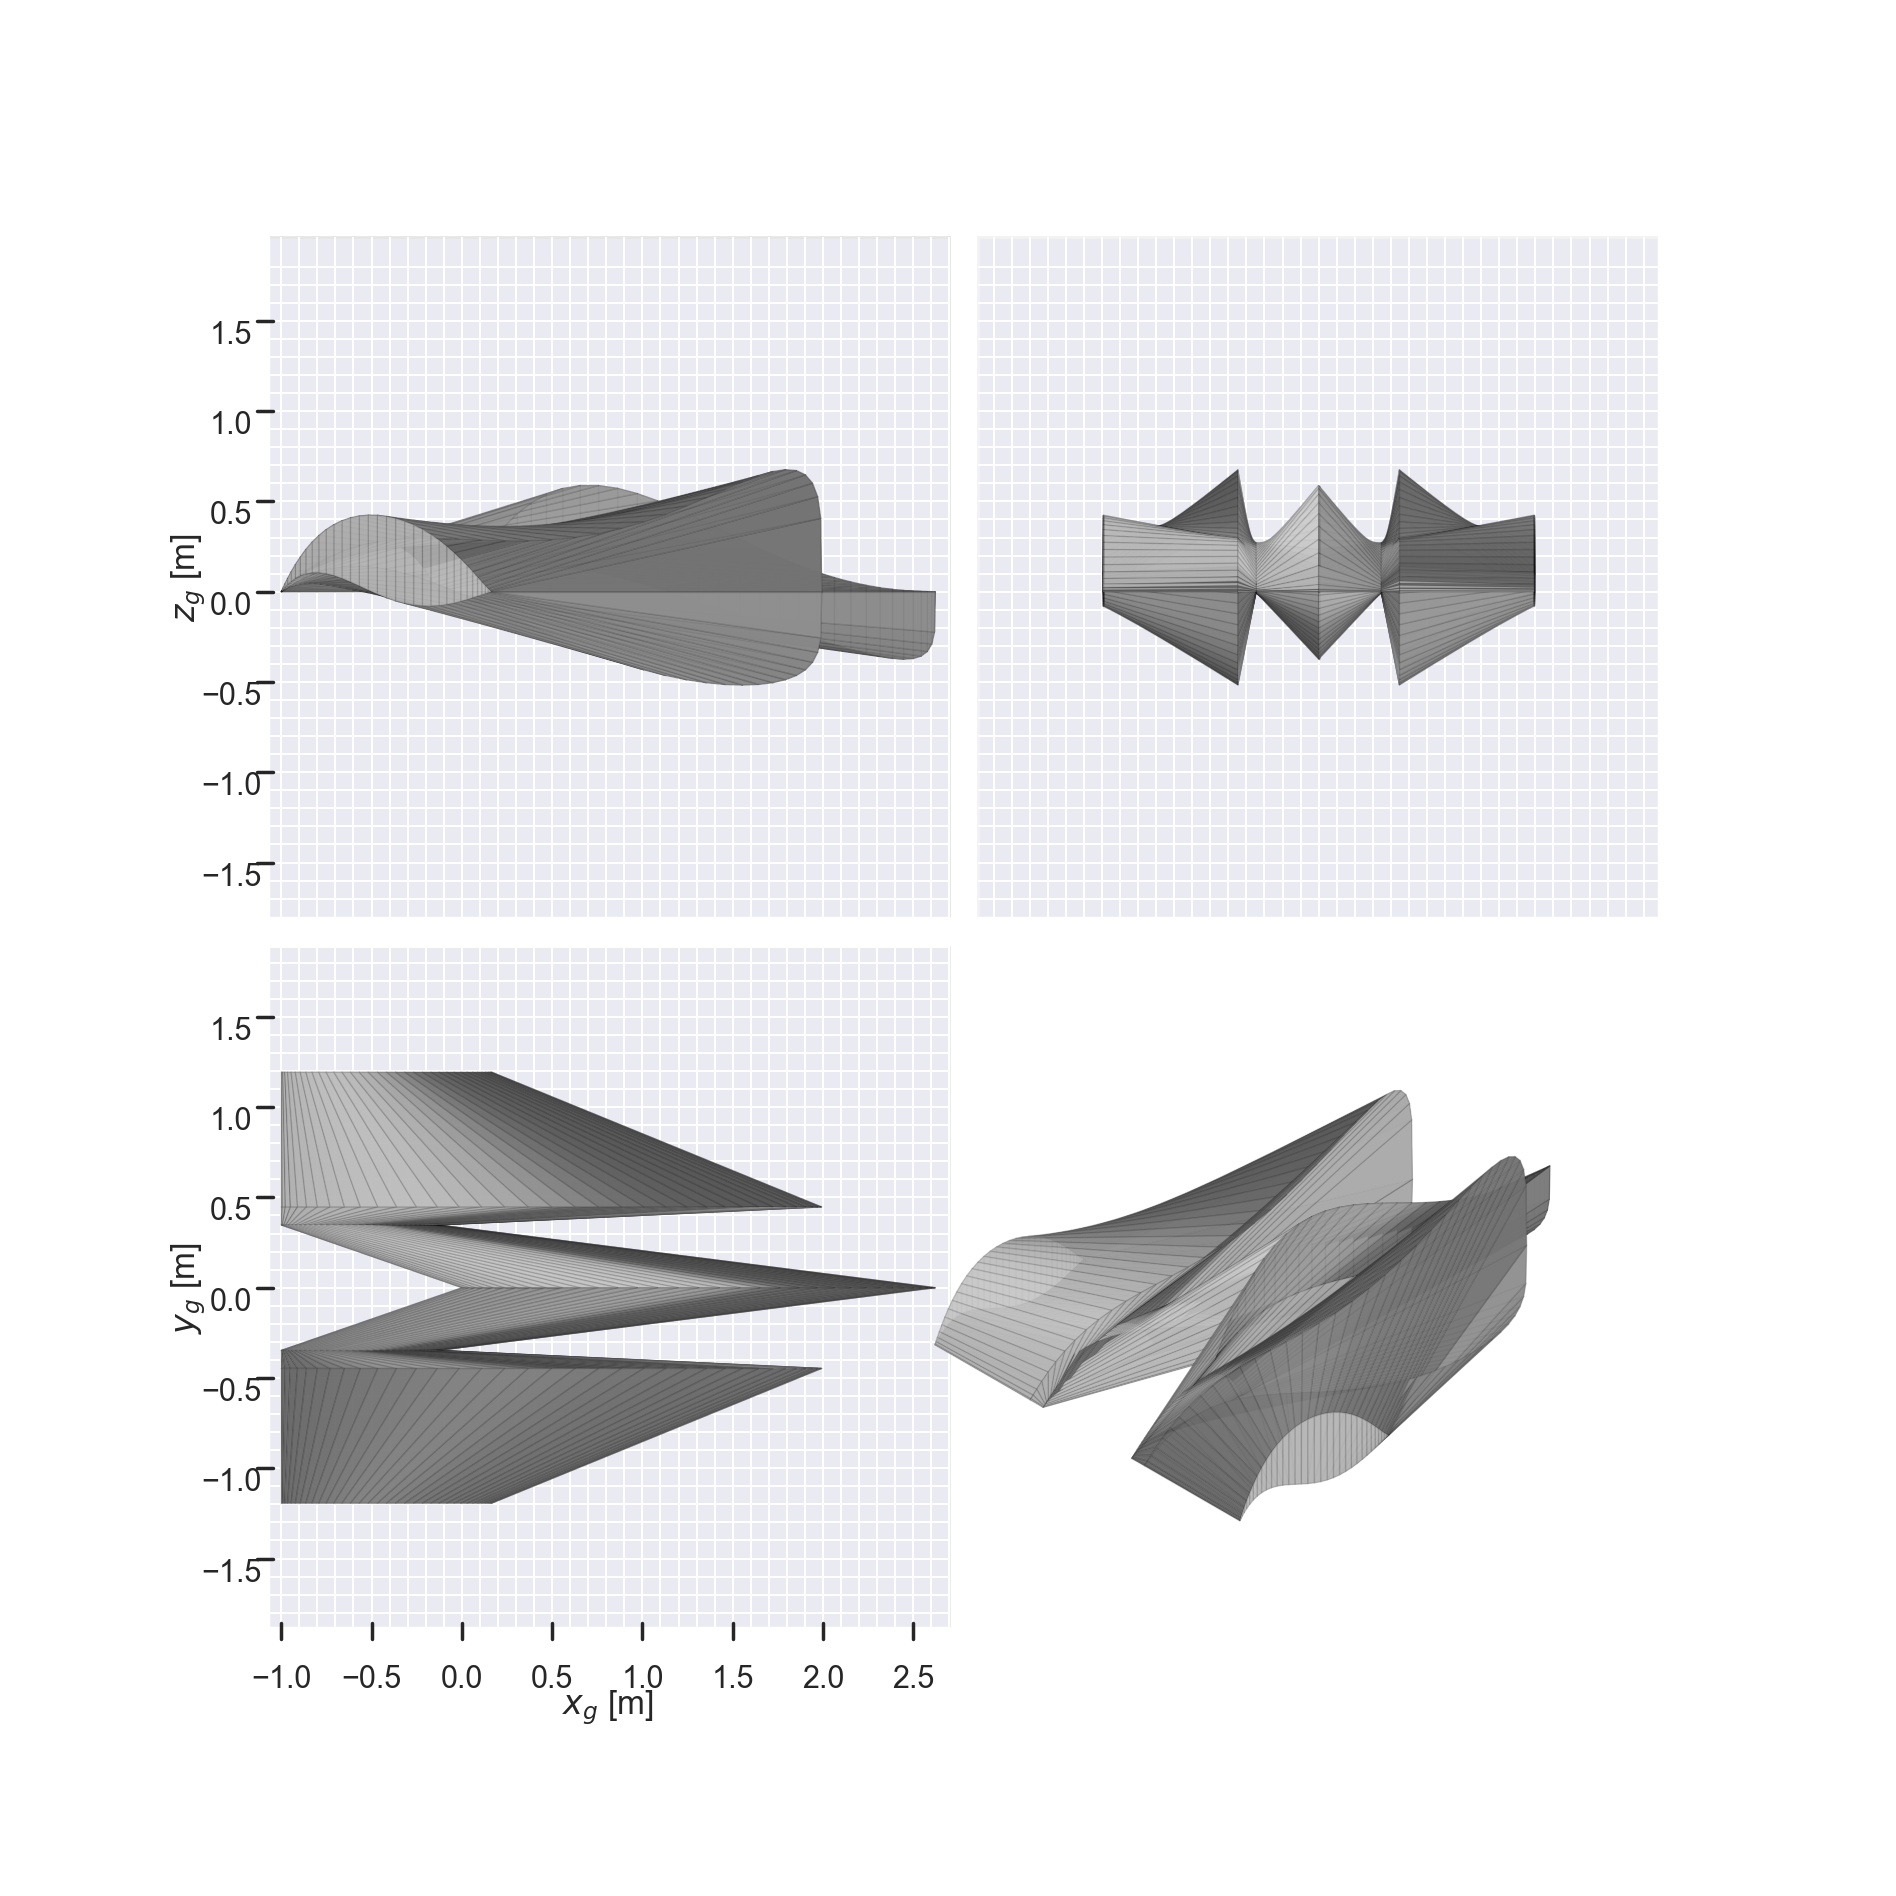

0

1

2

3

4

5

6

7

8

9

===

{'F_g': array([-1.13760193e+13, -2.61628755e+03, -7.19568053e+13]), 'F_b': (11376019295873.72, -2616.28754936685, 
71956805293107.36), 'F_w': (11376019295873.72, -2616.28754936685, 71956805293107.36), 'M_g': 
array([-1.11976646e+01,  2.27277881e+14, -6.93890289e+03]), 'M_b': (11.197664578948935, 227277881431717.88, 
6938.902886120952), 'M_w': (11.197664578948935, 227277881431717.88, 6938.902886120952), 'L': -71956805293107.36, 
'D': -11376019295873.72, 'Y': -2616.28754936685, 'l_b': 11.197664578948935, 'm_b': 227277881431717.88, 'n_b': 
6938.902886120952, 'CL': -84337414128.76355, 'CD': -13333333054.251213, 'CY': -3.0664358378903143, 'Cl': 
0.006027923776396393, 'Cm': 179730352761.21378, 'Cn': 3.7353483303998134}

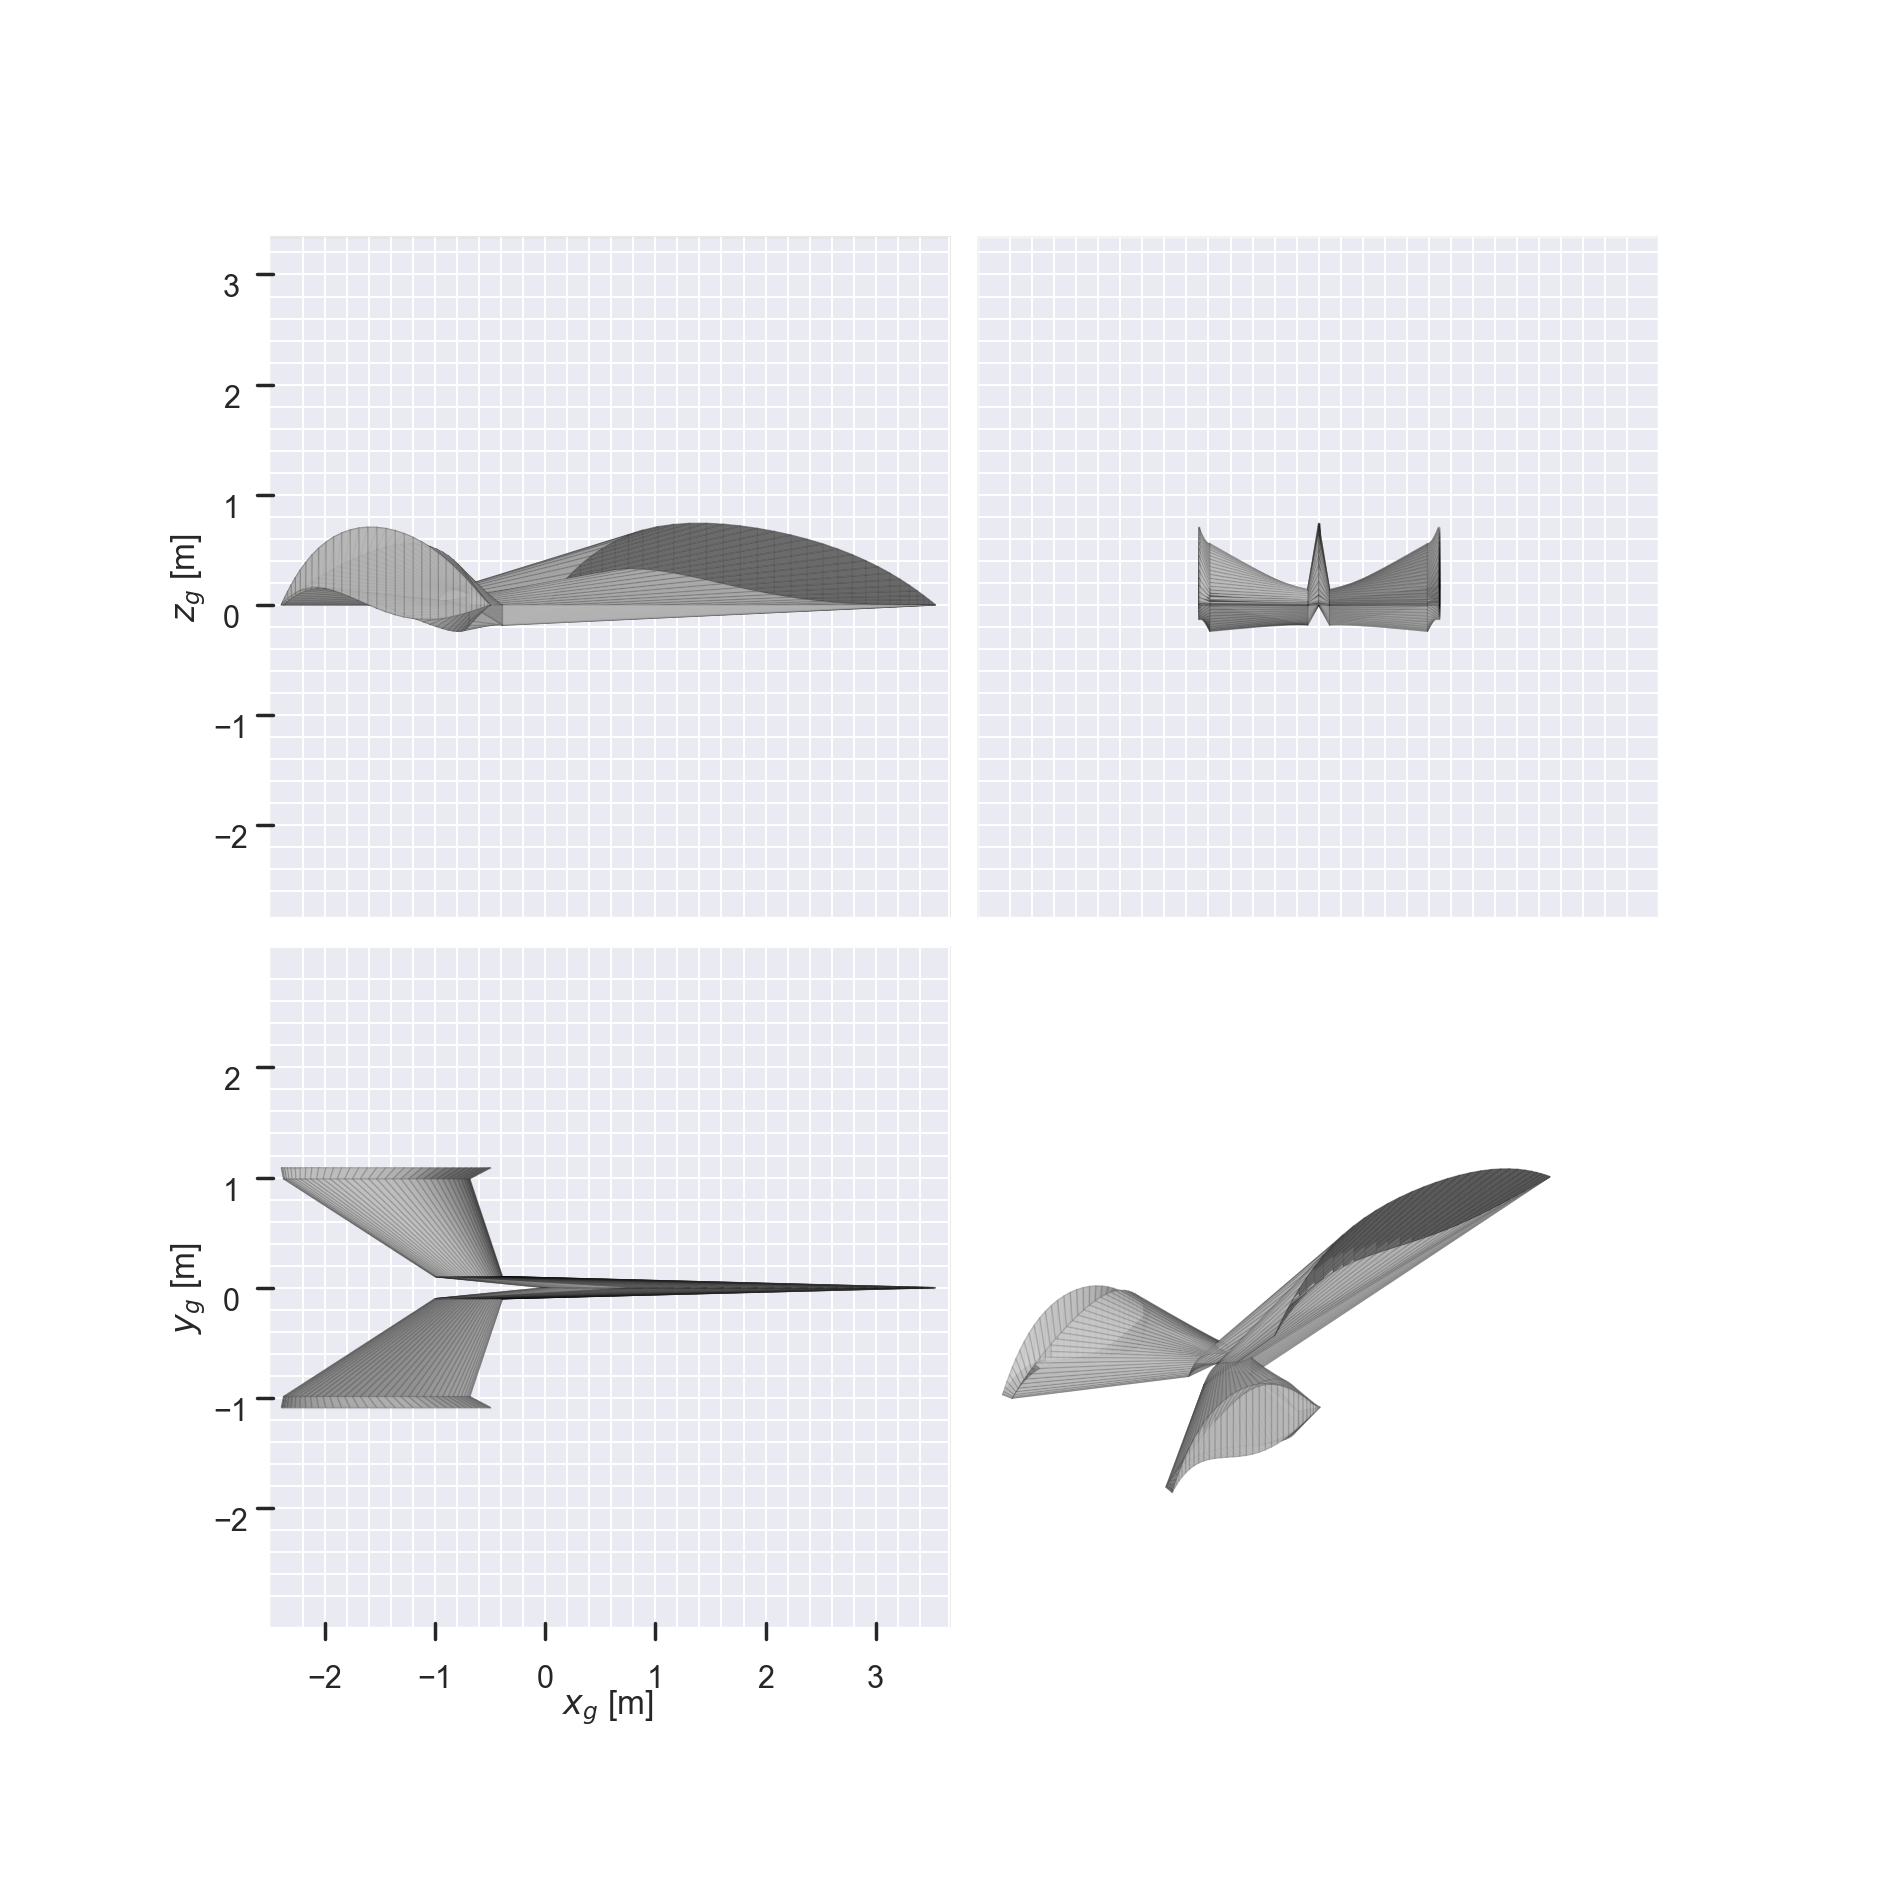

0

1

2

3

4

5

6

7

8

9

===

{'F_g': array([ 3.99332384e+10, -1.06596947e-02,  1.68186732e+10]), 'F_b': (-39933238375.72847, 
-0.01065969467163086, -16818673158.601154), 'F_w': (-39933238375.72847, -0.01065969467163086, -16818673158.601154),
'M_g': array([-6.74953461e-02,  2.10184793e+10,  1.58966064e-01]), 'M_b': (0.06749534606933594, 21018479253.89743, 
-0.158966064453125), 'M_w': (0.06749534606933594, 21018479253.89743, -0.158966064453125), 'L': 16818673158.601154, 
'D': 39933238375.72847, 'Y': -0.01065969467163086, 'l_b': 0.06749534606933594, 'm_b': 21018479253.89743, 'n_b': 
-0.158966064453125, 'CL': 4994623.462744601, 'CD': 11858931.28750088, 'CY': -3.165598178319631e-06, 'Cl': 
3.878445599578451e-06, 'Cm': 2363325.180256224, 'Cn': -9.134573997548996e-06}

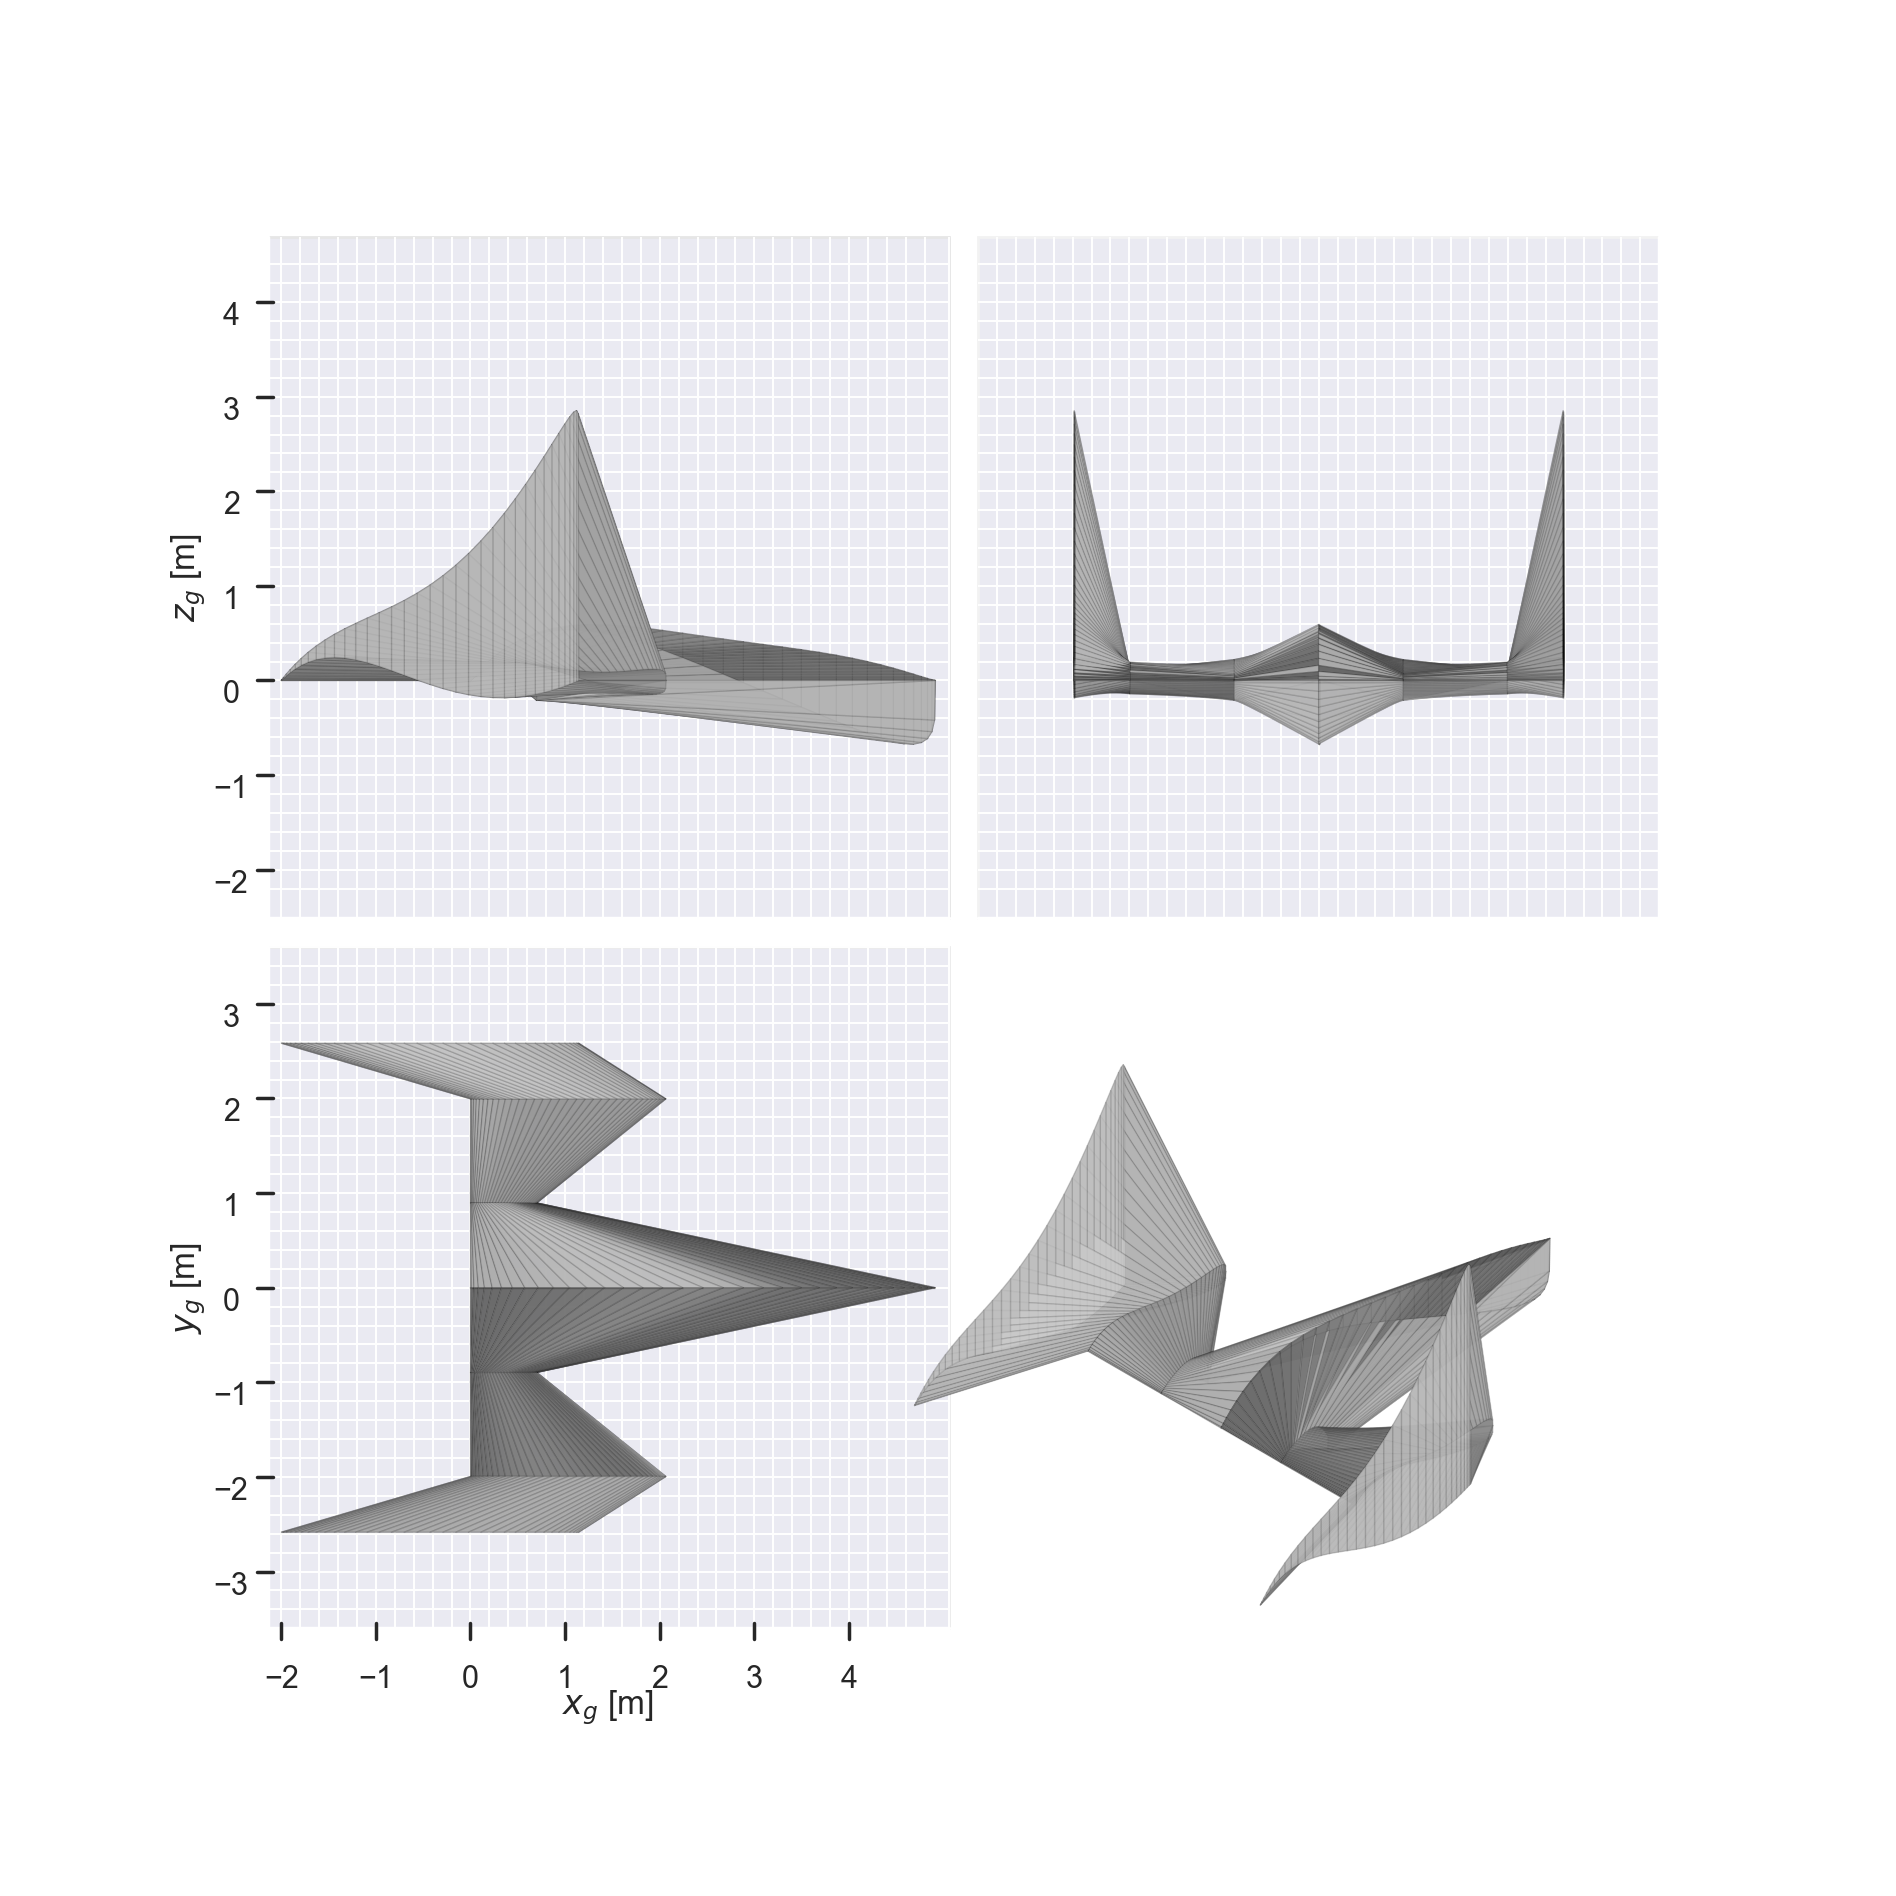

0

1

2

3

4

5

6

7

8

9

===

{'F_g': array([ 6.11470999e+12,  9.82903076e+02, -9.33918834e+12]), 'F_b': (-6114709992247.451, 982.903076171875, 
9339188342663.576), 'F_w': (-6114709992247.451, 982.903076171875, 9339188342663.576), 'M_g': 
array([-3.53001343e+02,  2.19501714e+13,  4.26136517e+03]), 'M_b': (353.0013427734375, 21950171422272.074, 
-4261.365173339844), 'M_w': (353.0013427734375, 21950171422272.074, -4261.365173339844), 'L': -9339188342663.576, 
'D': 6114709992247.451, 'Y': 982.903076171875, 'l_b': 353.0013427734375, 'm_b': 21950171422272.074, 'n_b': 
-4261.365173339844, 'CL': -17109798208.291382, 'CD': 11202413981.913376, 'CY': 1.8007210770966502, 'Cl': 
0.32510190248922005, 'Cm': 38986040426.4851, 'Cn': -3.924568428464161}

0

1

2

3

4

5

6

7

8

9

===

{'F_g': array([ 1.43659161e+12, -2.36130472e+04,  1.20827814e+12]), 'F_b': (-1436591609331.4265, 
-23613.047175912052, -1208278143704.0205), 'F_w': (-1436591609331.4265, -23613.047175912052, -1208278143704.0205), 
'M_g': array([-8.90227742e+03, -1.66664208e+12, -6.18306402e+04]), 'M_b': (8902.277424557868, -1666642082593.4626, 
61830.640208236764), 'M_w': (8902.277424557868, -1666642082593.4626, 61830.640208236764), 'L': 1208278143704.0205, 
'D': 1436591609331.4265, 'Y': -23613.047175912052, 'l_b': 8902.277424557868, 'm_b': -1666642082593.4626, 'n_b': 
61830.640208236764, 'CL': 272997458.2148223, 'CD': 324582431.5235567, 'CY': -5.335114181548717, 'Cl': 
0.2680976243591287, 'Cm': -173612709.8599556, 'Cn': 1.8620682059069371}

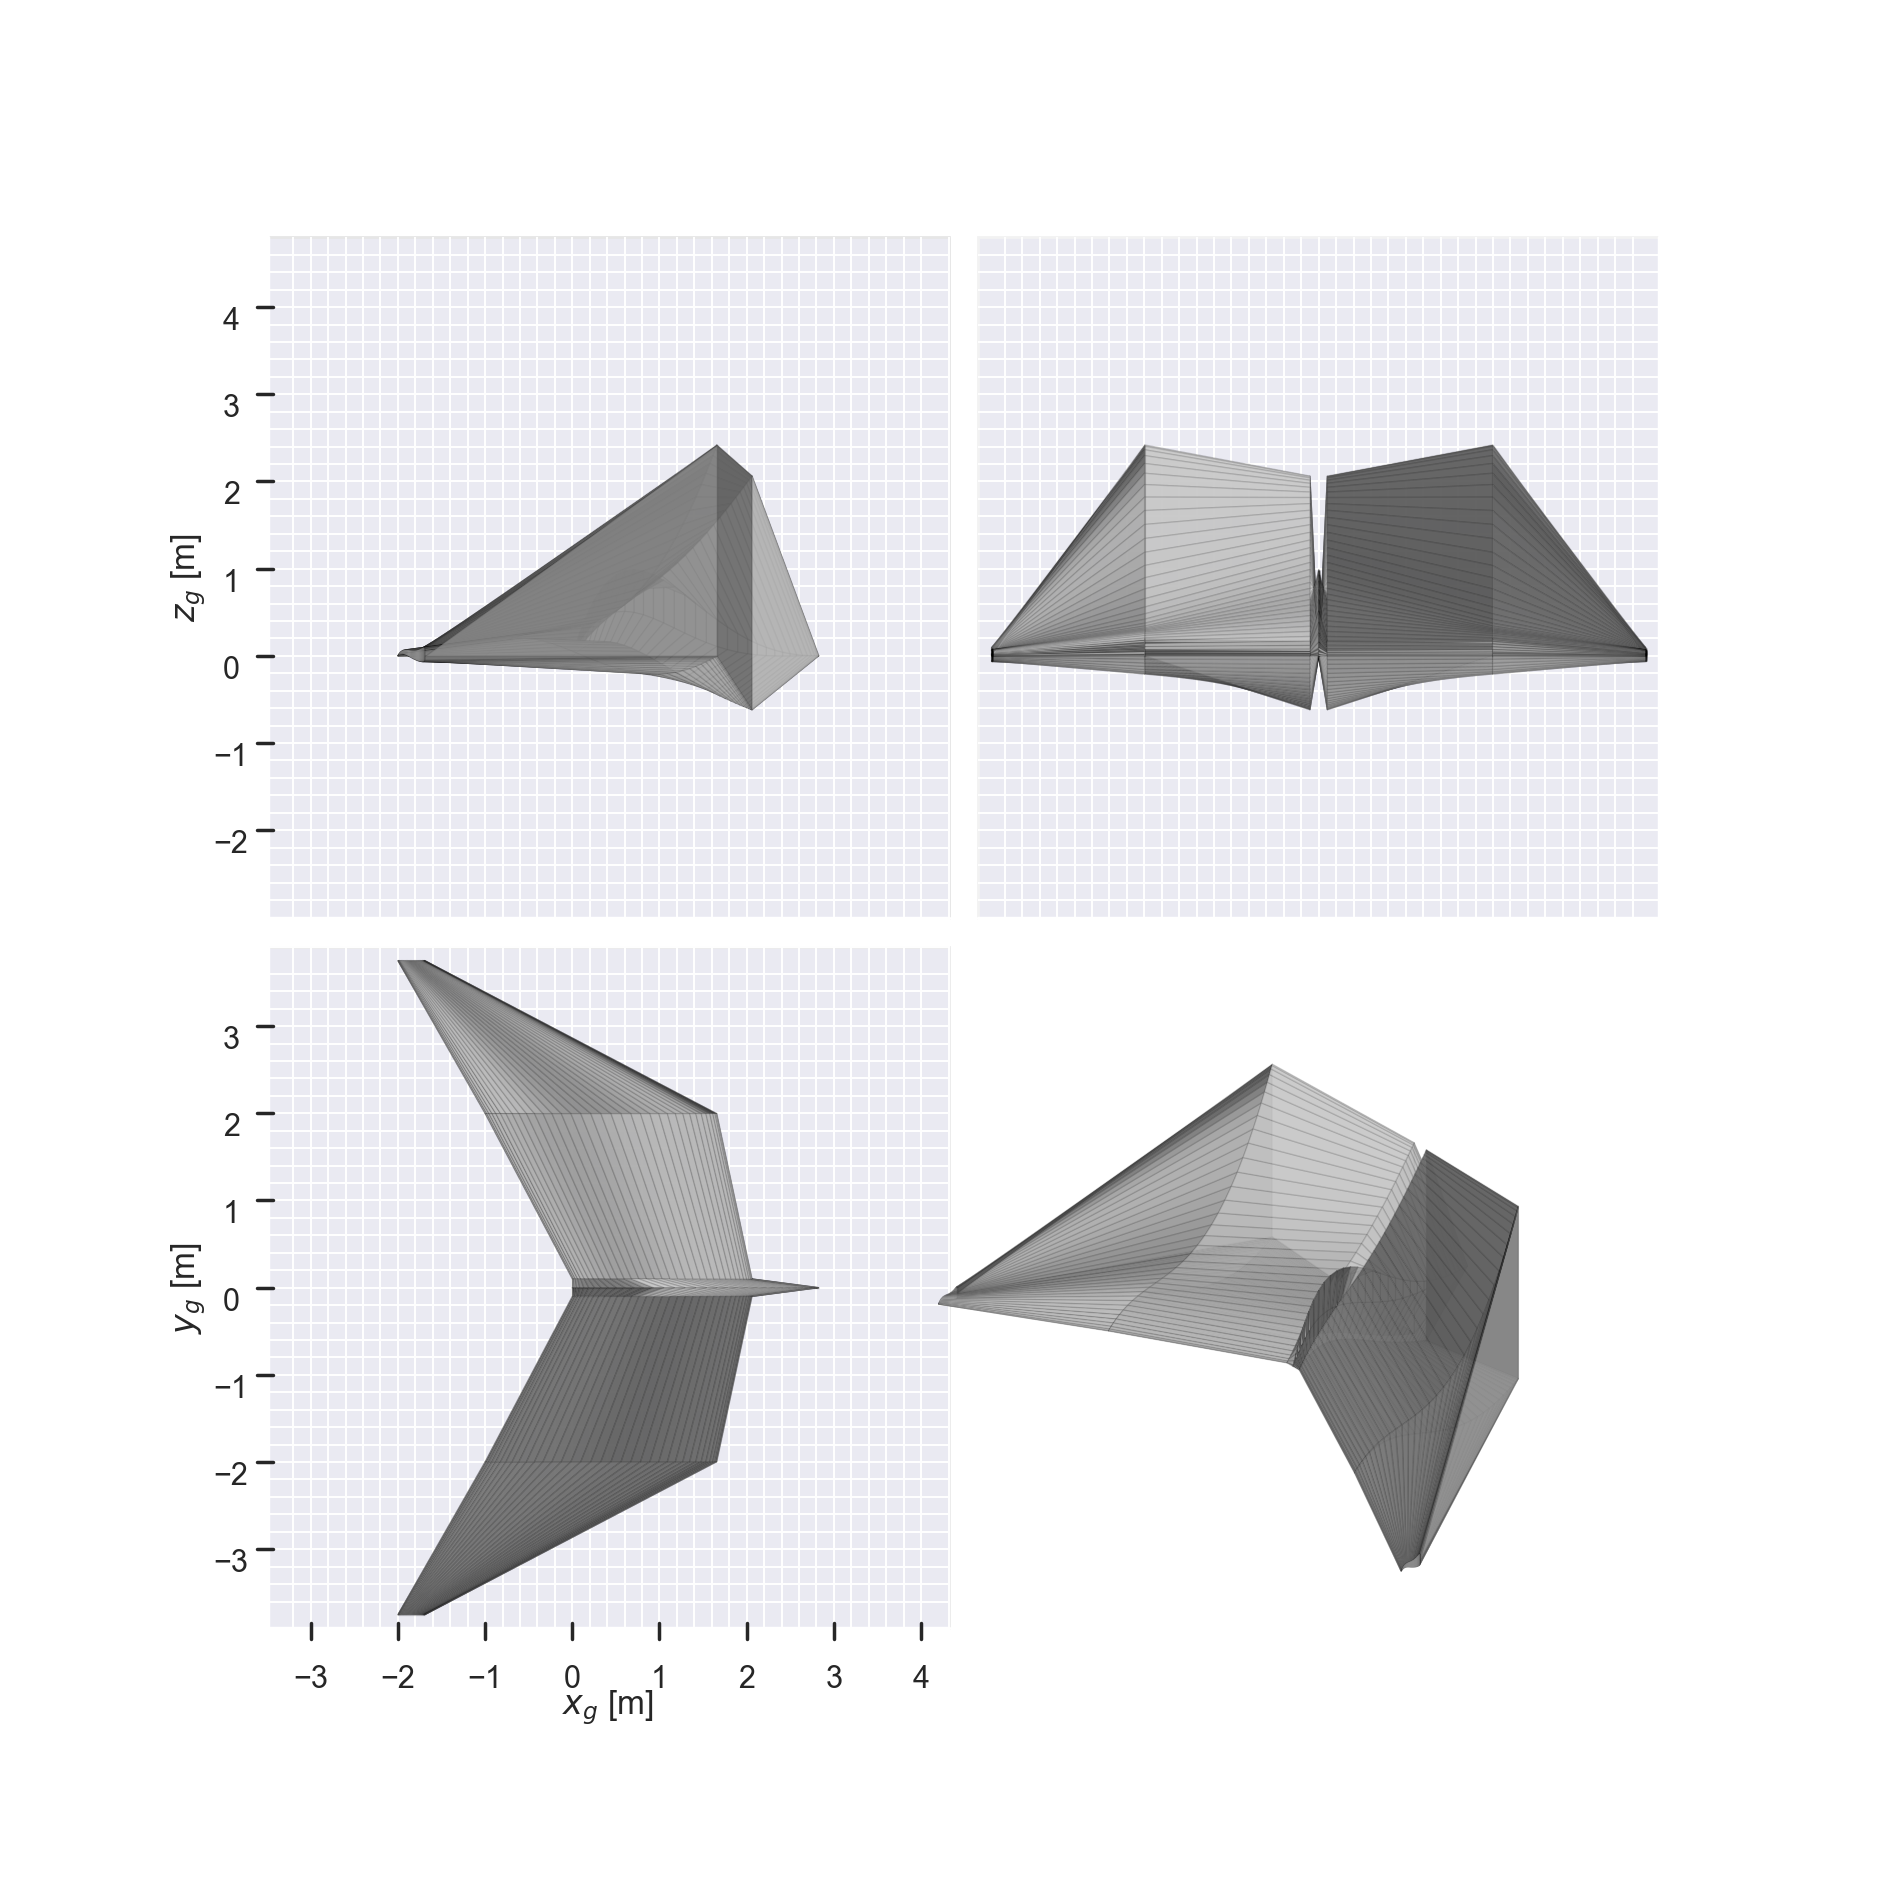

0

1

2

3

4

5

6

7

8

9

===

{'F_g': array([ 2.78783821e+12, -3.97077647e+02, -1.38326732e+13]), 'F_b': (-2787838208320.5674, 
-397.0776468501299, 13832673188553.455), 'F_w': (-2787838208320.5674, -397.0776468501299, 13832673188553.455), 
'M_g': array([ 3.70582733e+02,  2.27588397e+13, -5.95512092e+02]), 'M_b': (-370.5827333398156, 22758839716855.566, 
595.512092022138), 'M_w': (-370.5827333398156, 22758839716855.566, 595.512092022138), 'L': -13832673188553.455, 
'D': 2787838208320.5674, 'Y': -397.0776468501299, 'l_b': -370.5827333398156, 'm_b': 22758839716855.566, 'n_b': 
595.512092022138, 'CL': -4630932995.369241, 'CD': 933318655.6699723, 'CY': -0.1329345348839357, 'Cl': 
-0.03866809453948417, 'Cm': 2458372829.663619, 'Cn': 0.06213812949725999}

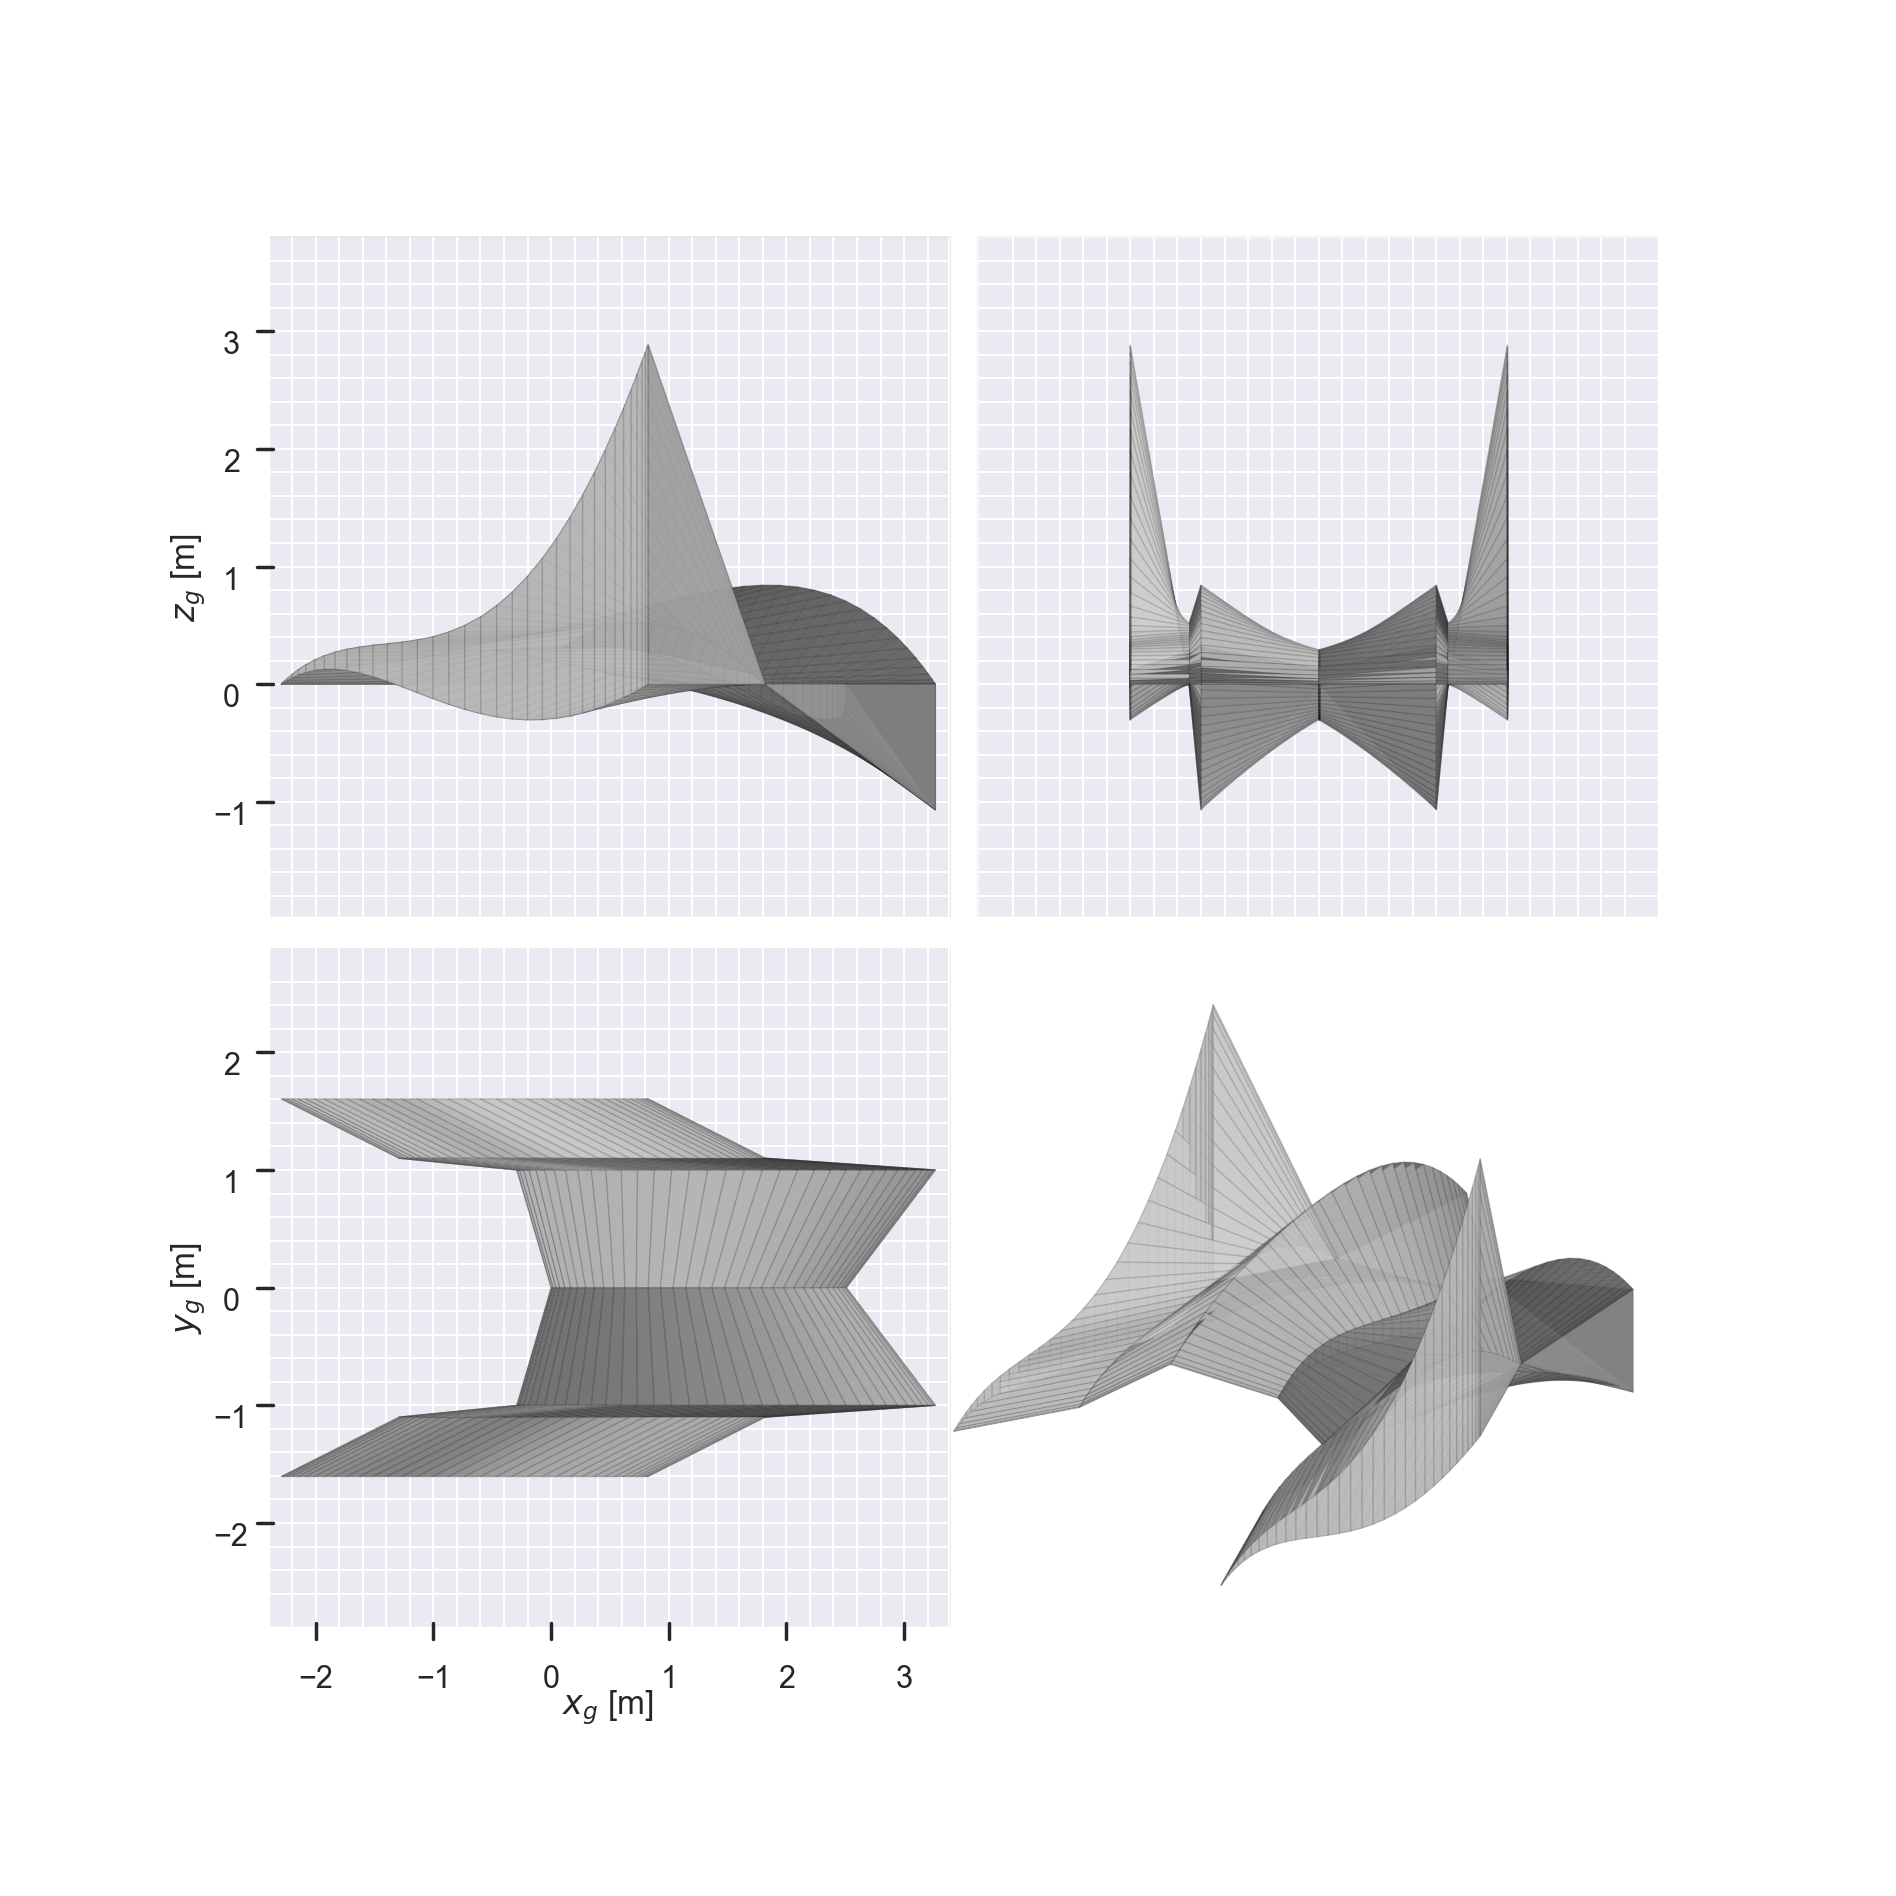

0

1

2

3

4

5

6

7

8

9

===

{'F_g': array([ 2.77331601e+18, -4.39349027e+09,  6.29362340e+18]), 'F_b': (-2.773316005028859e+18, 
-4393490268.3158245, -6.293623397309007e+18), 'F_w': (-2.773316005028859e+18, -4393490268.3158245, 
-6.293623397309007e+18), 'M_g': array([ 2.08985408e+09, -6.42916342e+18, -5.22804884e+09]), 'M_b': 
(-2089854084.5906305, -6.42916342230989e+18, 5228048837.628939), 'M_w': (-2089854084.5906305, 
-6.42916342230989e+18, 5228048837.628939), 'L': 6.293623397309007e+18, 'D': 2.773316005028859e+18, 'Y': 
-4393490268.3158245, 'l_b': -2089854084.5906305, 'm_b': -6.42916342230989e+18, 'n_b': 5228048837.628939, 'CL': 
9746421127298278.0, 'CD': 4294808252372556.5, 'CY': -6803839.961571553, 'Cl': -4723356.963606546, 'Cm': 
-2855565735049299.0, 'Cn': 11816107.67247748}

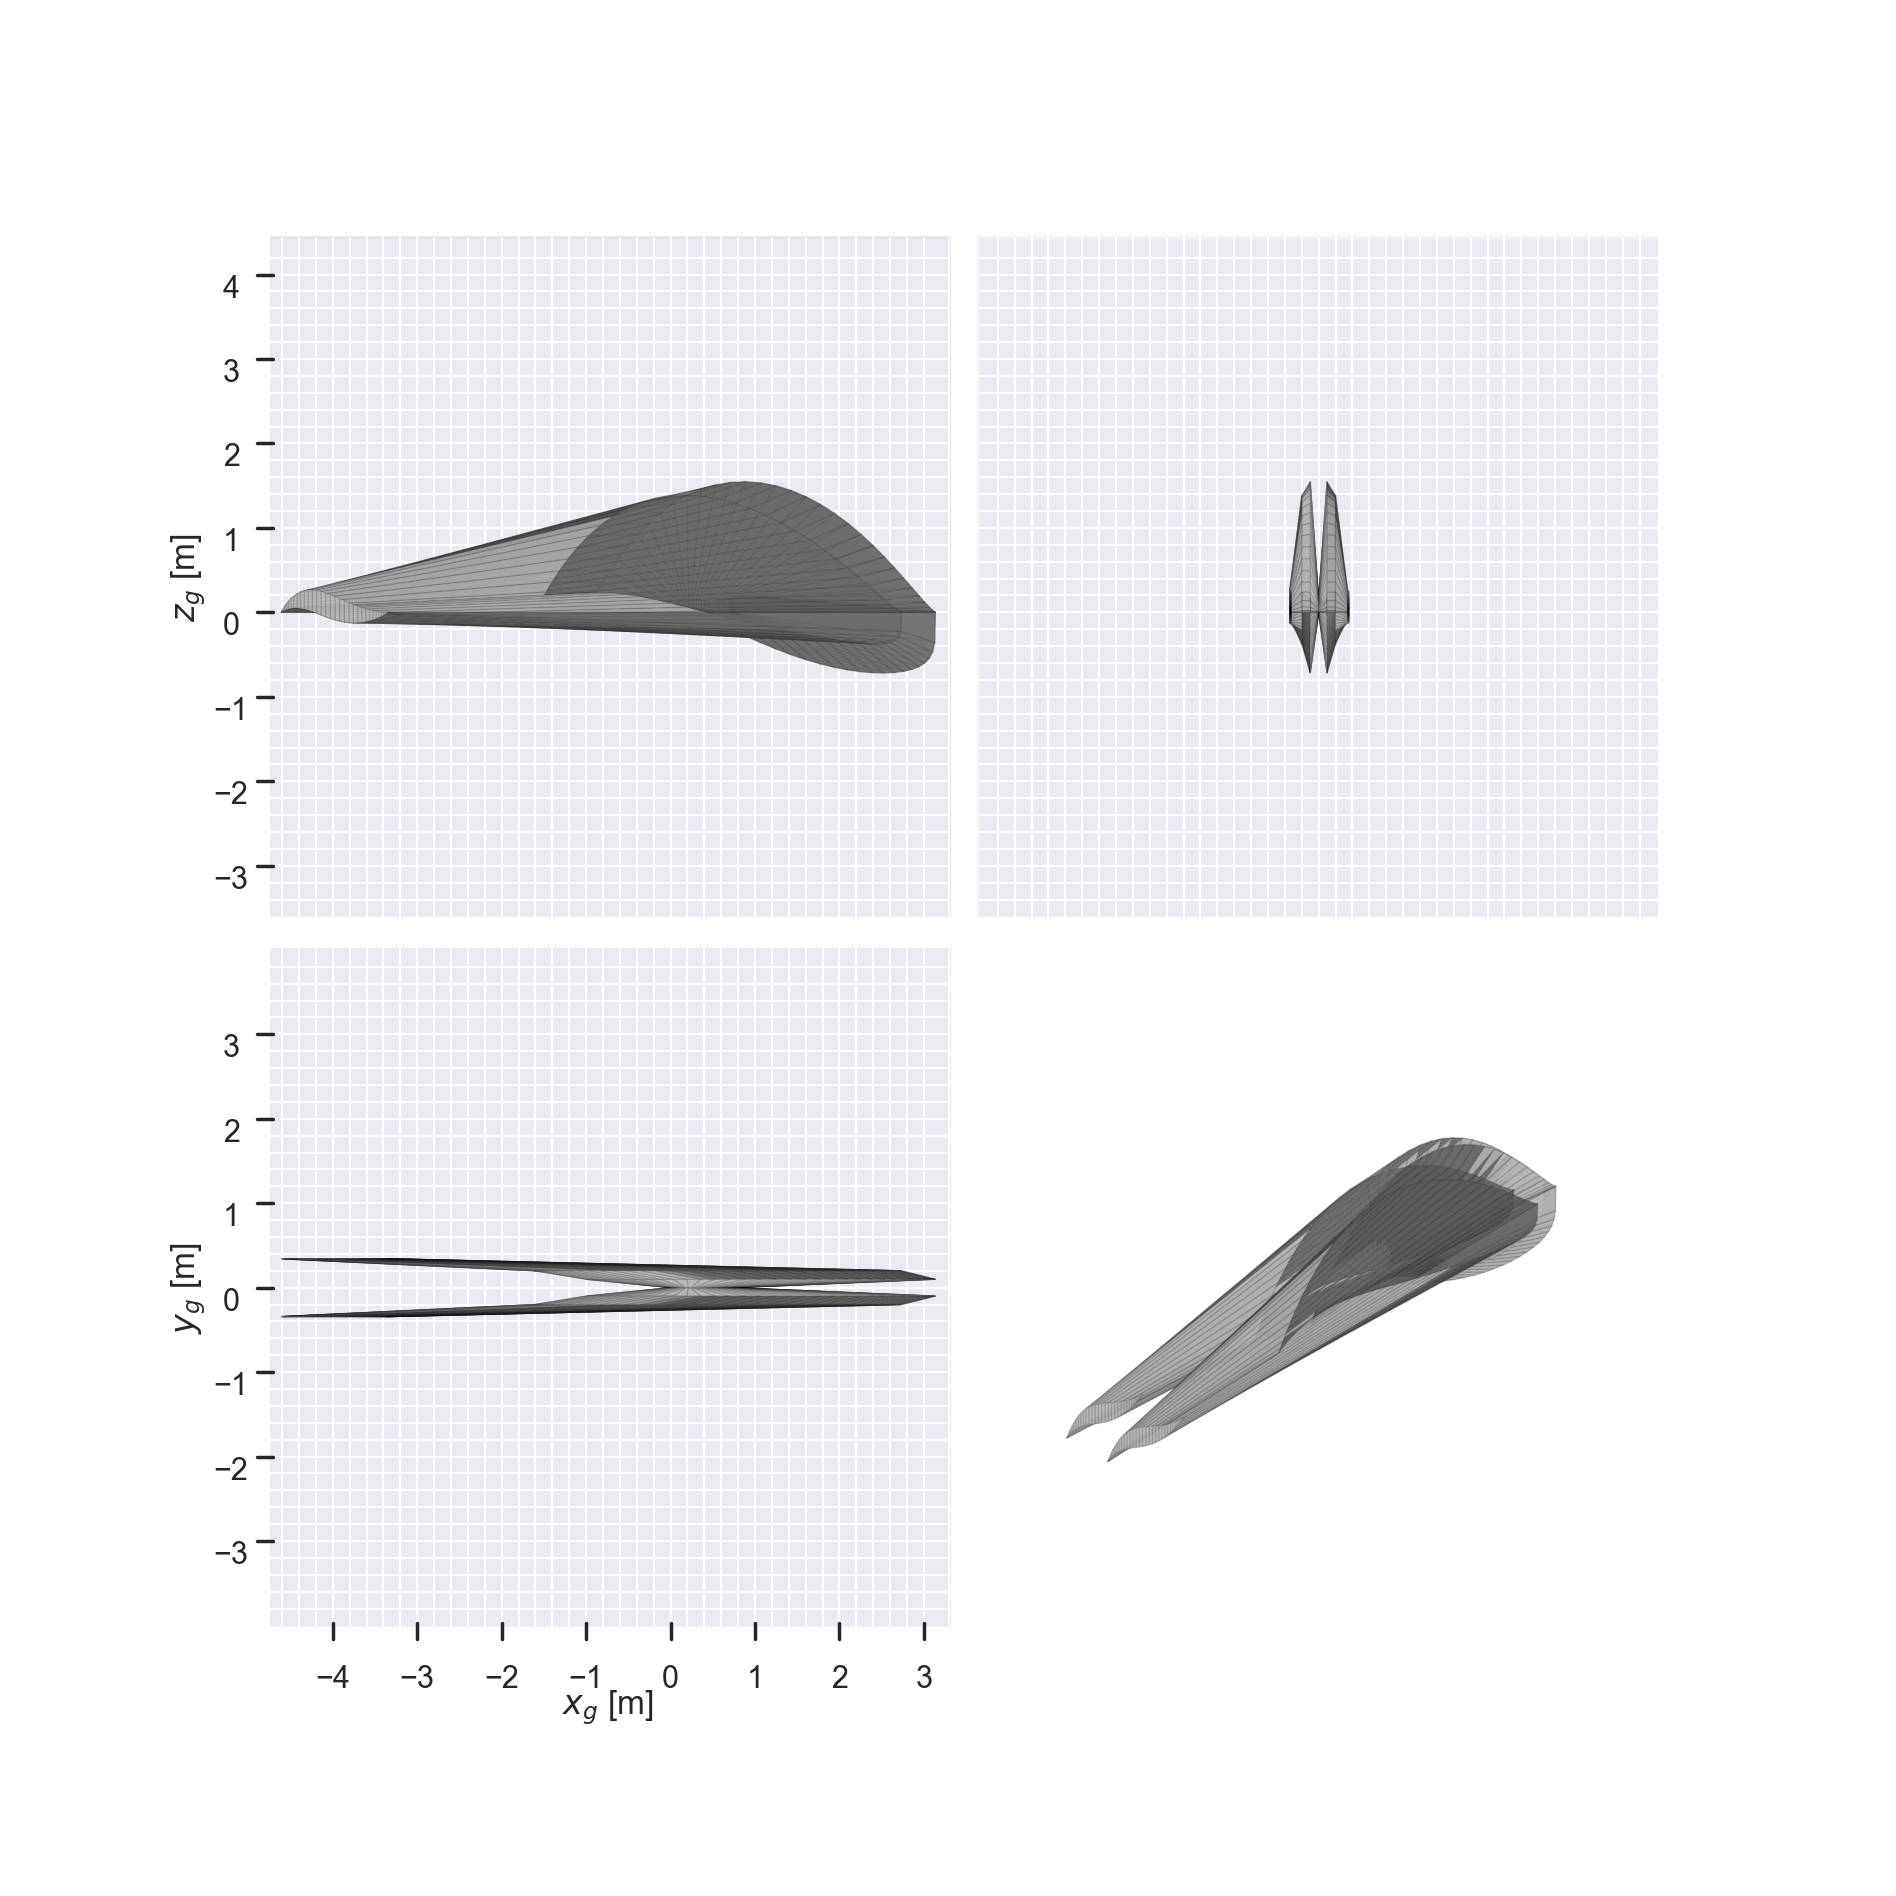

0

1

2

3

4

5

6

7

8

9

===

{'F_g': array([ 9.70759404e+14, -1.19775304e+05, -1.41236763e+16]), 'F_b': (-970759404082975.1, 
-119775.30440861592, 1.4123676284471832e+16), 'F_w': (-970759404082975.1, -119775.30440861592, 
1.4123676284471832e+16), 'M_g': array([-1.20303379e+04,  4.49438751e+16, -4.10718276e+05]), 'M_b': 
(12030.337935638847, 4.494387509909486e+16, 410718.27556283027), 'M_w': (12030.337935638847, 4.494387509909486e+16,
410718.27556283027), 'L': -1.4123676284471832e+16, 'D': 970759404082975.1, 'Y': -119775.30440861592, 'l_b': 
12030.337935638847, 'm_b': 4.494387509909486e+16, 'n_b': 410718.27556283027, 'CL': -9637808289374.016, 'CD': 
662433267600.8054, 'CY': -81.73306994870872, 'Cl': 3.961940823342502, 'Cm': 12535115981331.014, 'Cn': 
135.2614956912099}

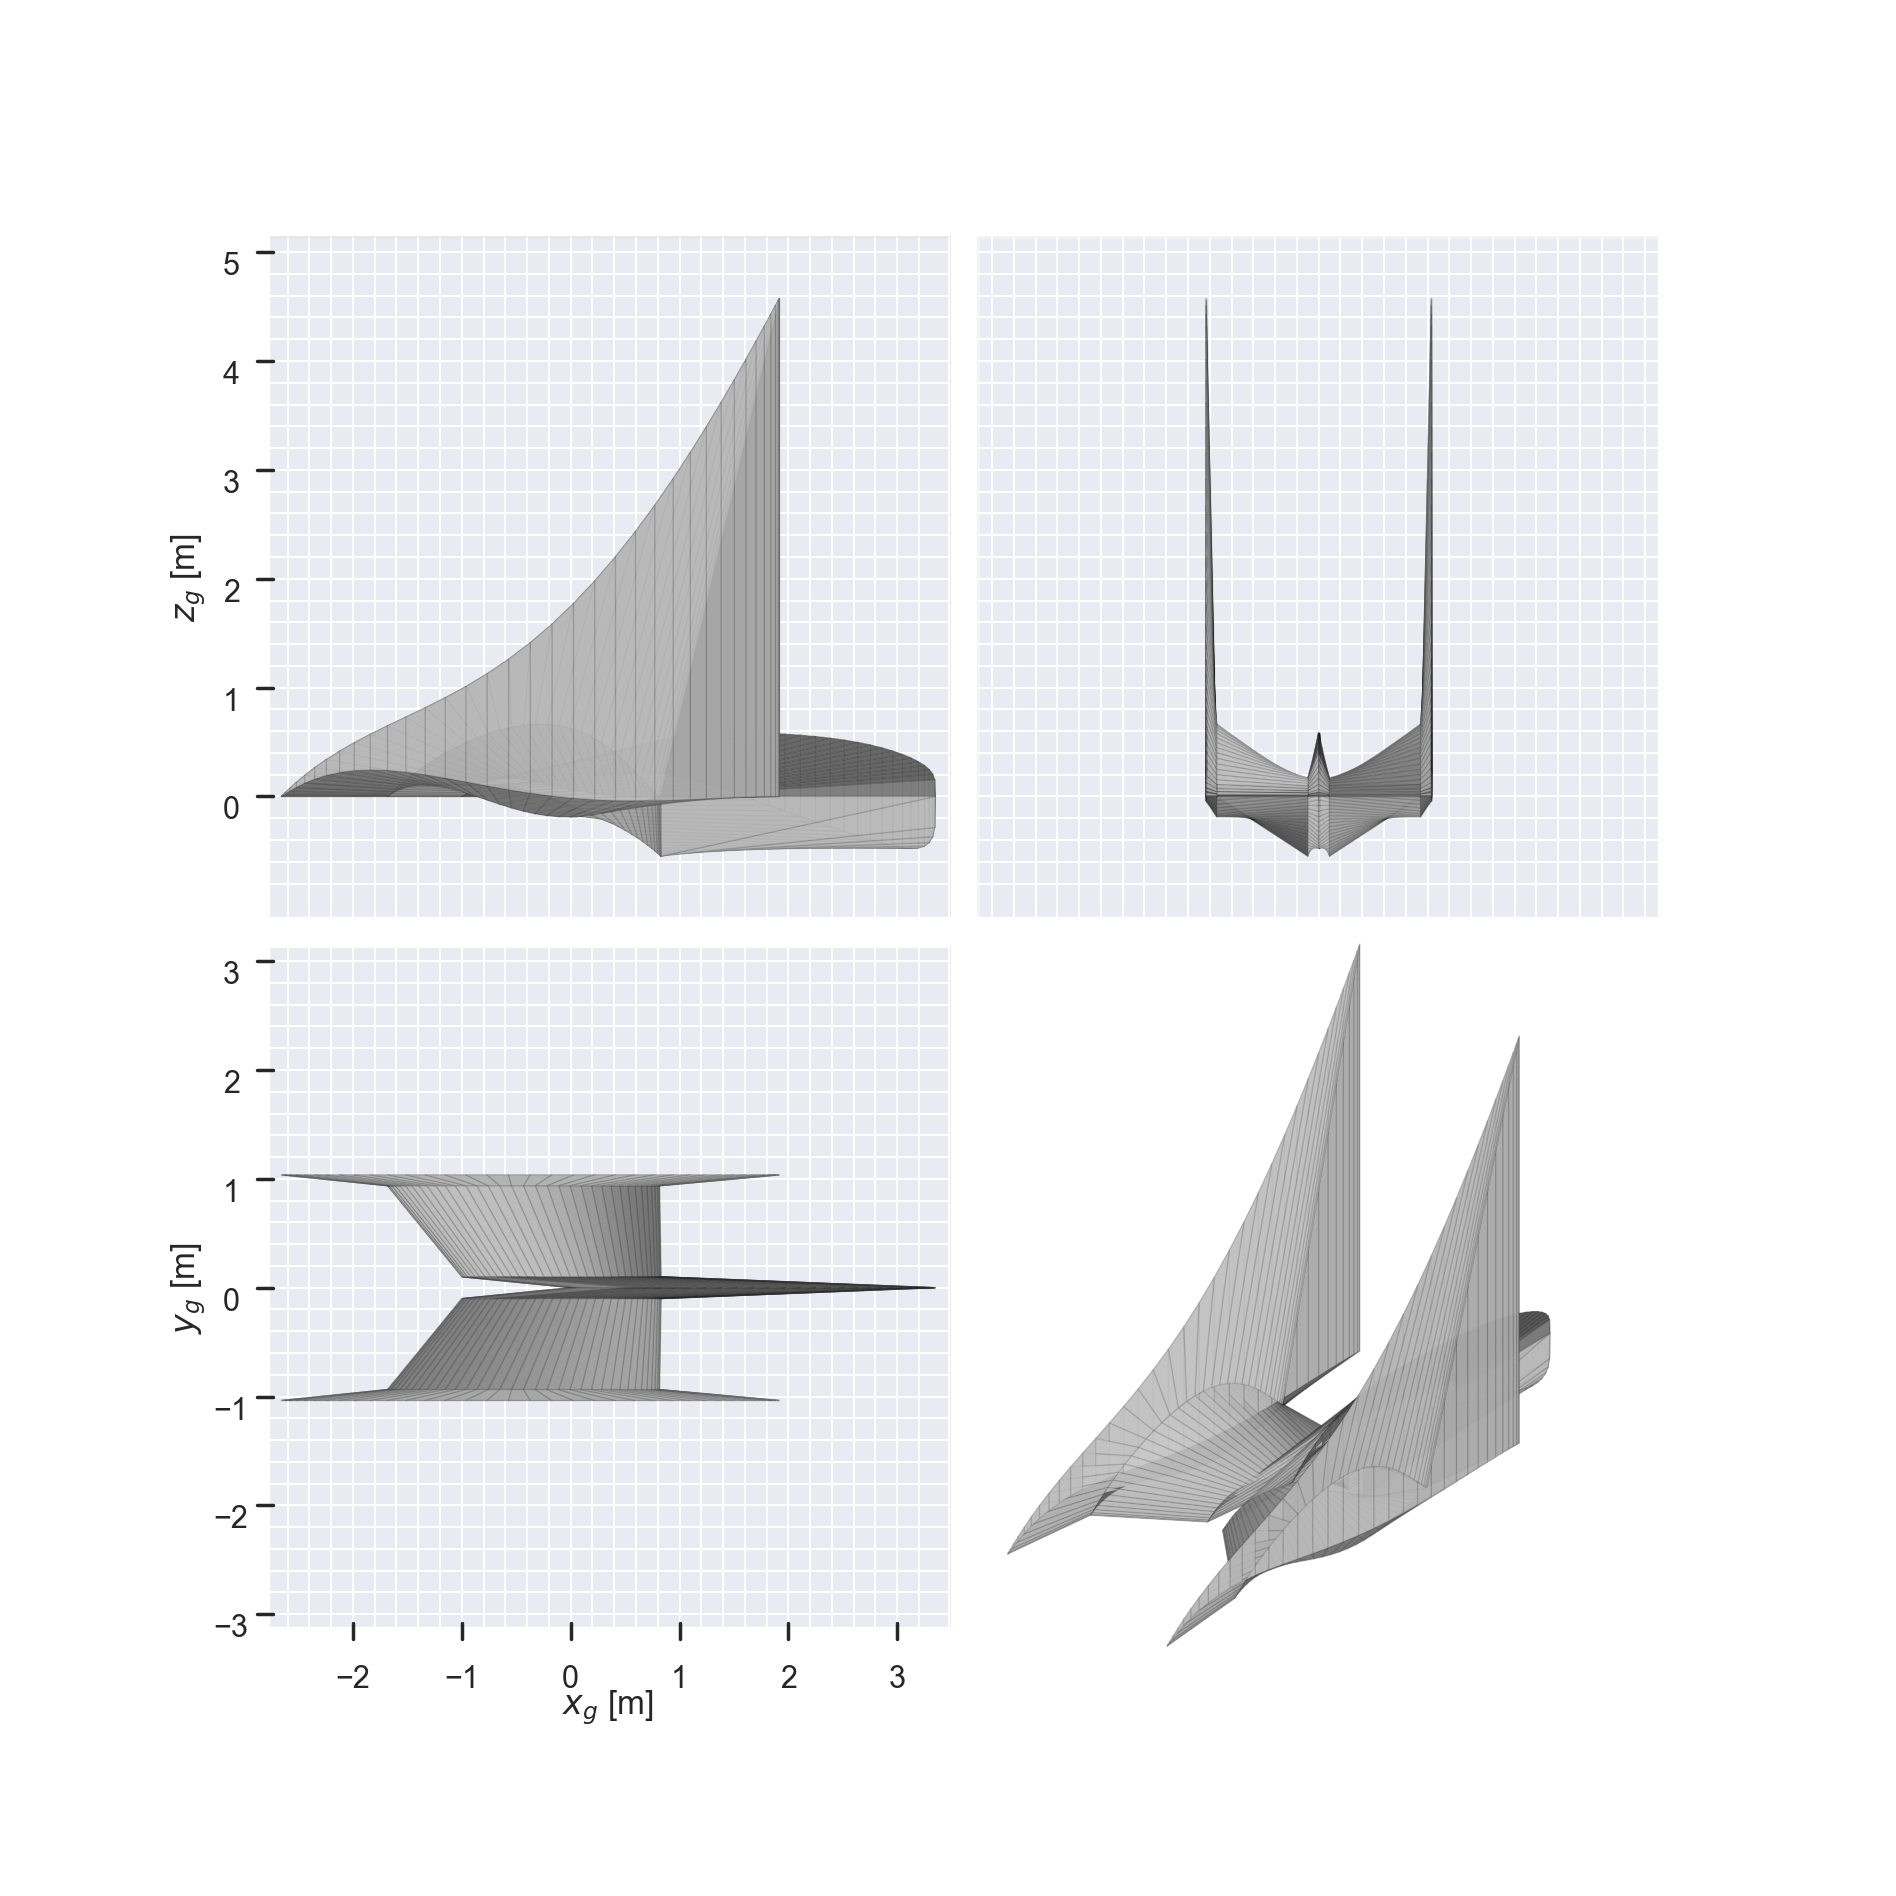

0

1

2

3

4

5

6

7

8

9

===

{'F_g': array([7.99857929e+03, 3.18590310e-09, 1.42923418e+03]), 'F_b': (-7998.579294859817, 3.185903096891707e-09,
-1429.2341773958972), 'F_w': (-7998.579294859817, 3.185903096891707e-09, -1429.2341773958972), 'M_g': 
array([-4.97493602e-10,  8.56779009e+03,  2.66072675e-09]), 'M_b': (4.974936018697917e-10, 8567.7900927073, 
-2.6607267500367016e-09), 'M_w': (4.974936018697917e-10, 8567.7900927073, -2.6607267500367016e-09), 'L': 
1429.2341773958972, 'D': 7998.579294859817, 'Y': 3.185903096891707e-09, 'l_b': 4.974936018697917e-10, 'm_b': 
8567.7900927073, 'n_b': -2.6607267500367016e-09, 'CL': 0.49052128246707827, 'CD': 2.745157816459392, 'CY': 
1.0934200270459069e-12, 'Cl': 2.0170975251700027e-14, 'Cm': 2.2838108529071075, 'Cn': -1.0787968573829696e-13}

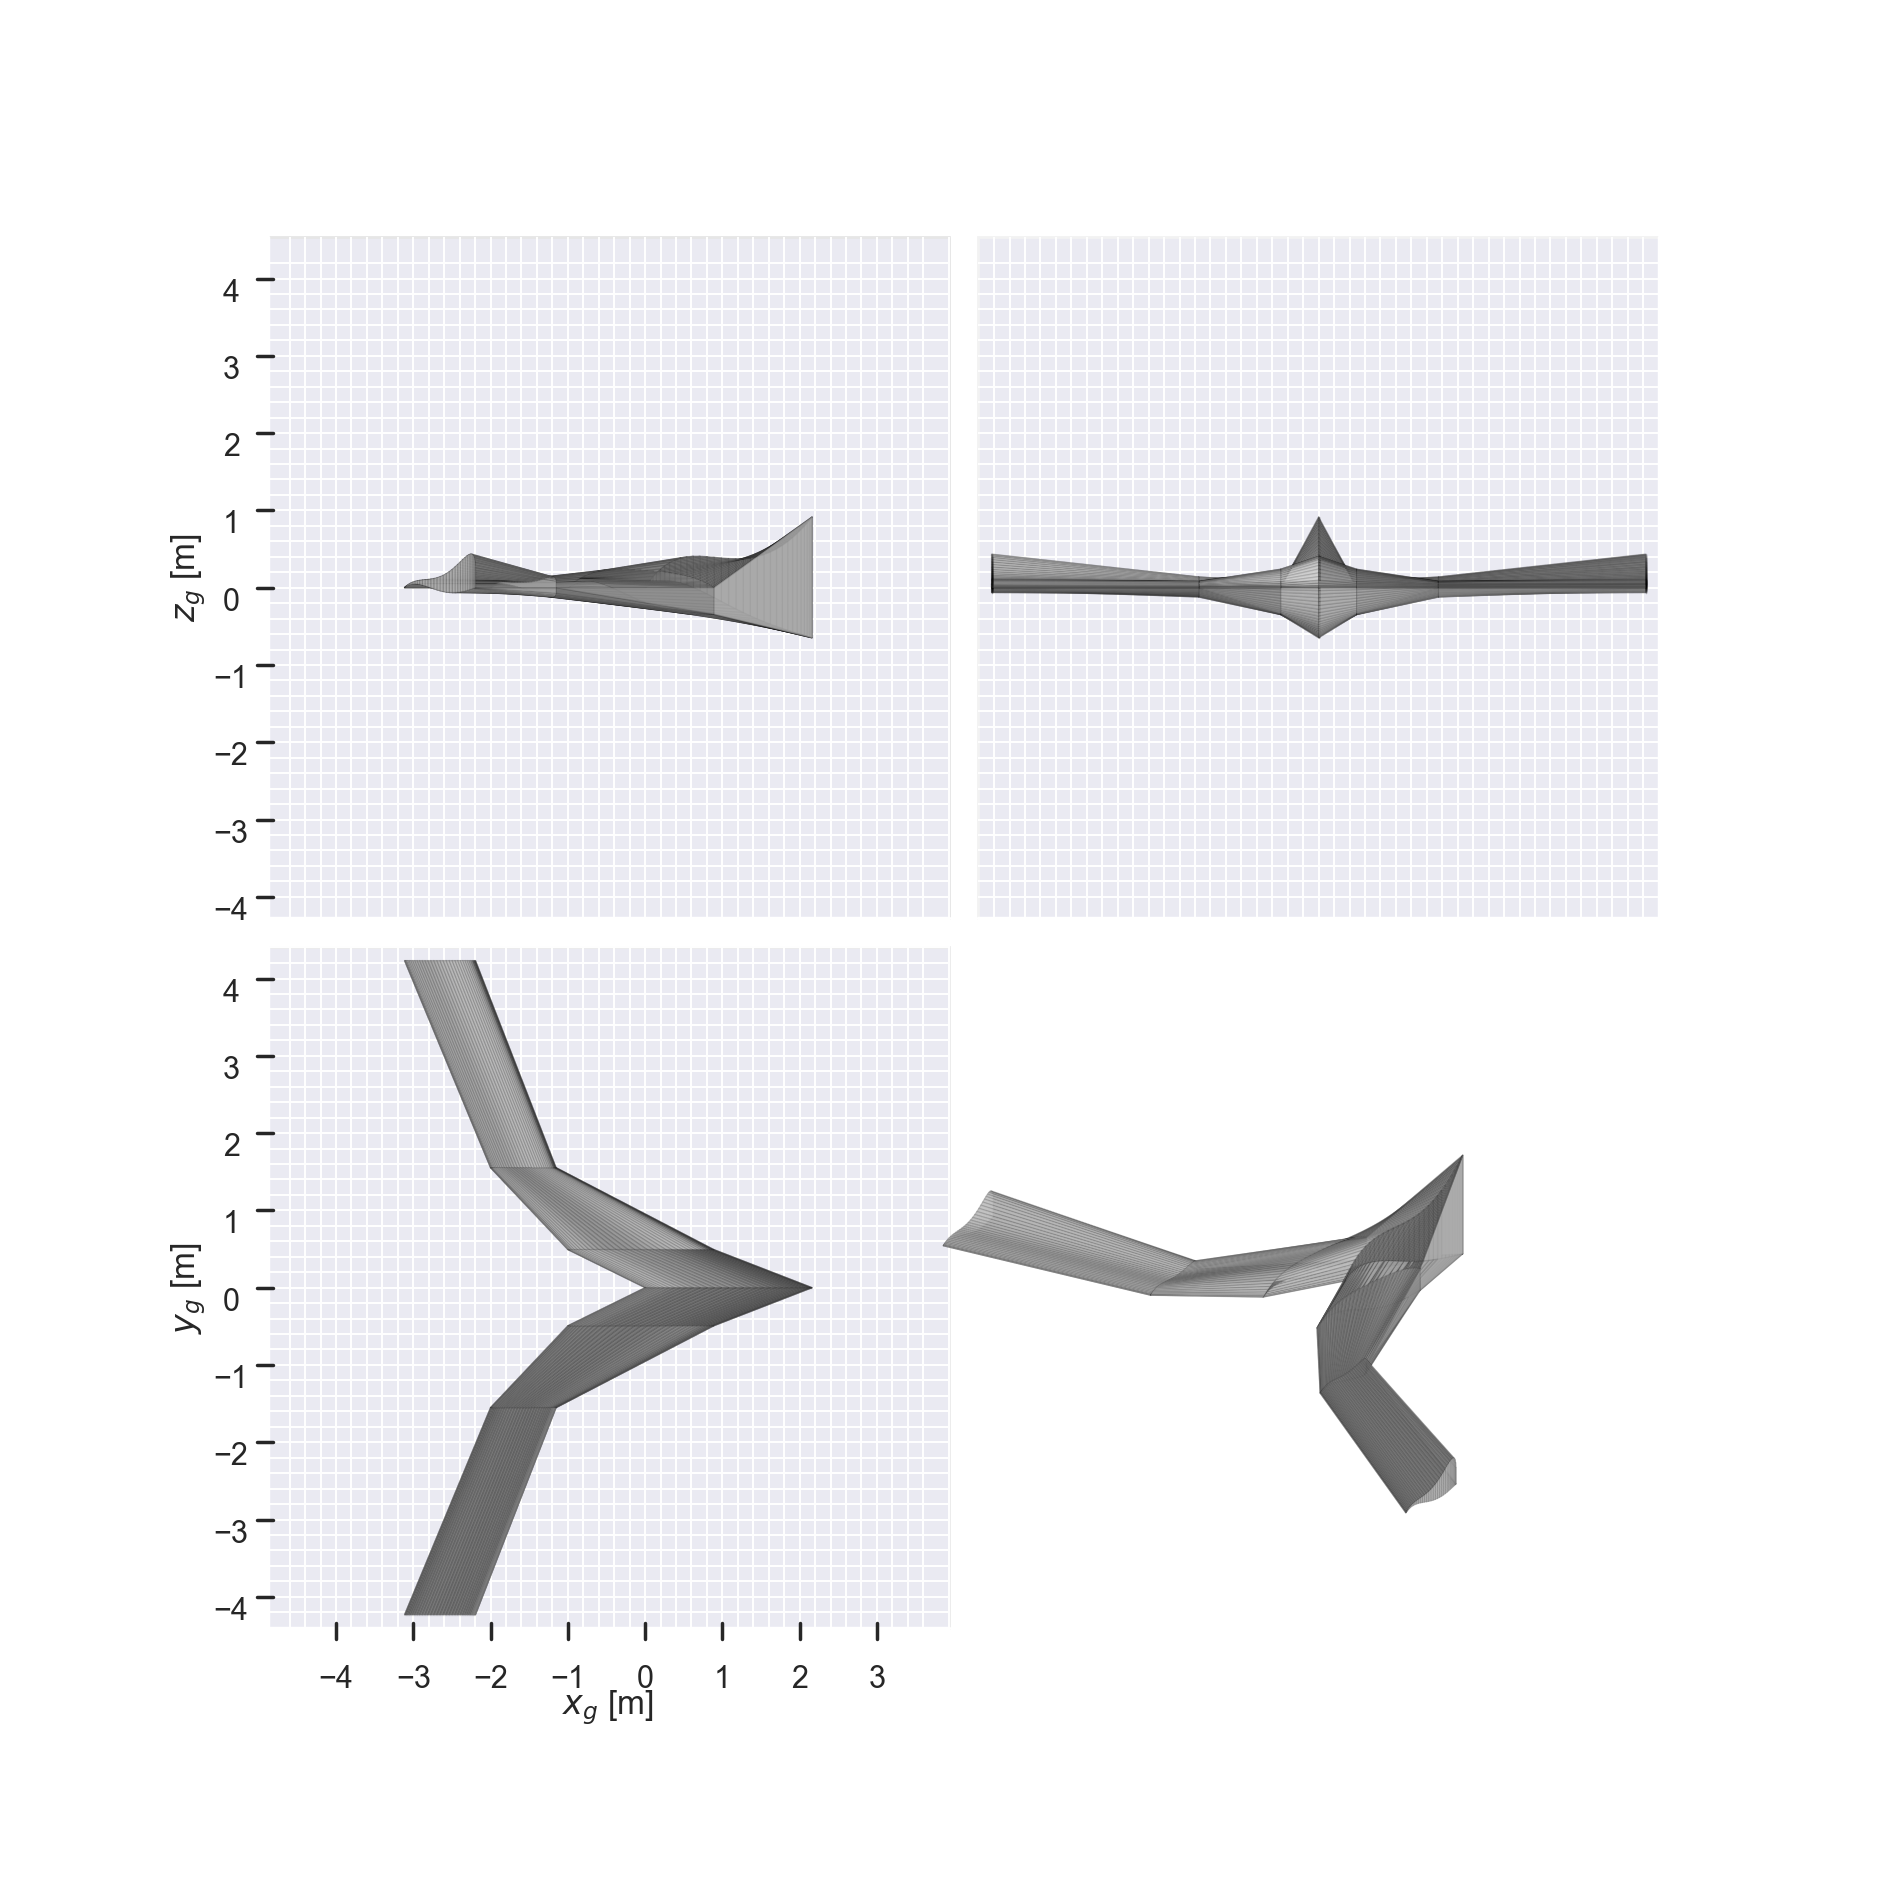

In [ ]:
num_episodes = 10
for _ in range(num_episodes):
    obs, info = env.reset()
    terminated = False
    for i in range(0,steps):
        print(i)
        action, nextHiddenState = model.predict(obs)
        obs, rewards, terminated, truncated, info = env.step(action)
        # if(i%5 == 0):
        #     env.render()
    
    print("===\n\n\n\n")
    env.render()
    env.reset()
env.close()